#### Utilities

##### Imports and setup

In [1]:
from google.colab import drive
import json
from datetime import datetime

import kagglehub
import os

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import f_oneway

# DT / RF
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn import svm
from sklearn.svm import SVC

# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

# Mount drive and set path
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Modeling_results/model_performance_final.json'

# Set seaborn palette
sns.set_palette("mako_r")

# Global dict for splits
data_splits = {}

Mounted at /content/drive


##### Methods

###### Plots

In [2]:
def plot_dist(df, column):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Distribution by {column}')
    plt.xlabel(column, )
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [3]:
def plot_feature_dist(X, y, label, cols=2, figsize=(16, 18), row_margin=0.8):
    df = X.copy()
    df[label] = y

    features = X.columns.tolist()
    rows = math.ceil(len(features) / cols)

    unique_classes = df[label].unique()
    cmap = plt.get_cmap('mako_r')
    colors = [cmap(0.1 + 0.8 * i / len(unique_classes)) for i in range(len(unique_classes))]
    palette = dict(zip(sorted(unique_classes), colors))

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        for cls in sorted(unique_classes):
            subset = df[df[label] == cls]
            sns.kdeplot(
                data=subset,
                x=feature,
                ax=axes[i],
                color=palette[cls],
                label=str(cls) if i == 0 else None,
                fill=False,
                linewidth=2
            )
        axes[i].set_title(feature)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.0))

    plt.tight_layout(h_pad=row_margin)
    plt.show()

In [4]:
def plot_hist(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
def plot_conf_mtx(model, X, y_true, class_names=None, normalize=False, ax=None):
    # Predict and get class labels
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)

    # Default class names if not provided
    if class_names is None:
        class_names = [str(i) for i in np.unique(y_true)]

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap=plt.get_cmap('mako_r'), values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_title("Confusion Matrix")

    if ax is None:
        plt.show()

###### Feature importance and selection

In [6]:
def run_anova(X, y):
    results = {}
    groups = y.unique()
    for col in X.columns:
        samples = [X[y == g][col] for g in groups]
        f_stat, p_val = f_oneway(*samples)
        results[col] = p_val
    return sorted(results.items(), key=lambda x: x[1])

In [7]:
def compute_mutual_info(X, y, title=""):
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    mi_series.plot(kind='bar')
    plt.title(f'Mutual Information with Target ({title})')
    plt.ylabel('MI Score')
    plt.show()

    return mi_series

In [8]:
def select_features(df, num_features, target='group', method='anova'):
    # Prepare data
    X, y = data_prep(df, target=target)
    target_col = 'Group' if target.lower() == 'group' else 'Type'
    col_names = df.drop(columns=[target_col]).columns

    # Choose scoring function
    if method.lower() == 'anova':
        score_func = f_classif
    elif method.lower() in ['mi', 'mutual_info']:
        score_func = mutual_info_classif
    else:
        raise ValueError("method must be 'anova' or 'mi'")

    # Feature selection
    selector = SelectKBest(score_func=score_func, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Selected features and scores
    selected_features = col_names[selector.get_support()].tolist()
    scores = pd.Series(selector.scores_, index=col_names)

    # Print selected features
    print(f"Top {num_features} features ({method}) for target '{target}':")
    for i, feature in enumerate(selected_features):
        print(f"{i+1}: {feature}")

    return X_selected

###### Data preprocessing and preparation

In [9]:
def data_prep(df, target='group', scale=True):
    # Determine target column name
    target_col = 'Group' if target.lower() == 'group' else 'Type'

    # Select numerical features
    num_cols = df.drop(columns=[target_col]).columns
    X = df[num_cols]

    # Optionally scale features
    if scale:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else:
        X = X.values

    # Target
    y = df[target_col]

    return X, y

In [10]:
def data_split(X, y, train_ratio=0.75, val_ratio=0.15, test_ratio=0.10, random_state=42):
    # First split: train vs (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_ratio), random_state=random_state)

    # Second split: val vs test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
def get_splits(model_name):
  if model_name not in data_splits:
    raise ValueError(f"No data splits found for model {model_name}")

  splits = data_splits[model_name]

  return splits["X_train"], splits["X_val"], splits["X_test"], splits["y_train"], splits["y_val"], splits["y_test"]

###### Modeling and evaluation

In [12]:
def evaluate_and_save(model, model_name, save_path=save_path, test=False):
    # Retrieve splits
    X_train, X_val, X_test, y_train, y_val, y_test = get_splits(model_name)

    # Select data based on evaluation type
    if test:
        X_eval, y_eval = X_test, y_test
        eval_name = f"{model_name}_test"
    else:
        X_eval, y_eval = X_val, y_val
        eval_name = model_name
        # Train model
        model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_eval)

    # Metrics
    report_dict = classification_report(y_eval, y_pred, output_dict=True)
    acc = accuracy_score(y_eval, y_pred)

    print(f"=== {model_name} ===")
    print(classification_report(y_eval, y_pred))
    print(f"Accuracy: {acc:.4f}\n")

    # Prepare data to save
    entry = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": eval_name,
        "accuracy": acc,
        "report": report_dict
    }

    # Load existing file or create new list
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = []
    else:
        data = []

    # Append new entry and save
    data.append(entry)
    with open(save_path, "w") as f:
        json.dump(data, f, indent=4)

    return

In [13]:
def save_nn_history(history, model_name, class_names, save_path=save_path, test=False):
    # Retrieve splits
    _, X_val, X_test, _, y_val, y_test = get_splits(model_name)

    # Select data based on evaluation type
    if test:
        X_eval, y_eval = X_test, y_test
        eval_name = f"{model_name}_test"
    else:
        X_eval, y_eval = X_val, y_val
        eval_name = model_name

    # Predict
    y_pred_probs = history.model.predict(X_eval, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Metrics
    report_dict = classification_report(y_eval, y_pred, output_dict=True)
    acc = accuracy_score(y_eval, y_pred)

    print(f"=== {model_name} ===")
    print(classification_report(y_eval, y_pred))
    print(f"Accuracy: {acc:.4f}\n")

    entry = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": eval_name,
        "accuracy": acc,
        "report": report_dict,
        "history": history.history
    }

    # Save JSON
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = []
    else:
        data = []
    data.append(entry)
    with open(save_path, "w") as f:
        json.dump(data, f, indent=4)

    plot_conf_mtx(history.model, X_eval, y_eval, class_names=class_names, normalize=True)

In [14]:
def get_top_models(save_path, top_n=5):
    # Load saved results
    if not os.path.exists(save_path):
        raise FileNotFoundError(f"No file found at {save_path}")

    with open(save_path, "r") as f:
        data = json.load(f)

    # Convert to DataFrame
    records = []
    for entry in data:
        model = entry["model"]
        acc = entry["accuracy"]
        f1_weighted = entry["report"]["weighted avg"]["f1-score"]
        records.append({
            "model": model,
            "accuracy": acc,
            "f1_weighted": f1_weighted
        })
    df = pd.DataFrame(records)

    # Split into group/type
    df_group = df[df["model"].str.contains("group", case=False)].copy()
    df_type = df[df["model"].str.contains("type", case=False)].copy()

    # Sort and select top N
    top_group = df_group.sort_values(
        by=["accuracy", "f1_weighted"], ascending=False
    ).head(top_n)

    top_type = df_type.sort_values(
        by=["accuracy", "f1_weighted"], ascending=False
    ).head(top_n)

    return top_group, top_type

# Data collection

In [15]:
# Download latest version
path = kagglehub.dataset_download("mercheovejero/theory-of-mind-in-remitted-bipolar-disorder")

print("Path to dataset files:", path)

100%|██████████| 3.09k/3.09k [00:00<00:00, 8.14MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mercheovejero/theory-of-mind-in-remitted-bipolar-disorder/versions/1


In [16]:
file_name = os.path.join(path, 'Database MiniPONS.csv')

df = pd.read_csv(file_name, delimiter=';')
df.head()

,Group,Type,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,Bipolar,BD I,47,40,9,11,9,11,18,22,23,17
1,Bipolar,BD I,49,49,13,13,11,12,24,25,24,25
2,Bipolar,BD I,45,43,9,11,13,10,21,22,24,19
3,Bipolar,BD I,53,44,10,10,12,12,25,19,24,20
4,Bipolar,BD II,50,50,14,13,11,12,23,27,23,27


# Exploratory Data Analysis

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Group             277 non-null    object
 1   Type              277 non-null    object
 2   Age               277 non-null    int64 
 3   Right_answers     277 non-null    int64 
 4   Audio_prosody     277 non-null    int64 
 5   Combined_channel  277 non-null    int64 
 6   Face_video        277 non-null    int64 
 7   Body_video        277 non-null    int64 
 8   Positive_valence  277 non-null    int64 
 9   Negative_valence  277 non-null    int64 
 10  Dominant          277 non-null    int64 
 11  Submissive        277 non-null    int64 
dtypes: int64(10), object(2)
memory usage: 26.1+ KB


In [18]:
df.describe()

,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000
mean,48.718412,47.079422,11.425993,12.339350,11.794224,11.519856,23.555957,23.523466,23.454874,23.624549
std,12.452524,5.231680,2.122800,1.931903,1.693199,1.912147,3.215893,3.132981,3.125796,3.033003
min,21.000000,28.000000,3.000000,6.000000,8.000000,5.000000,13.000000,10.000000,12.000000,13.000000
25%,39.000000,44.000000,10.000000,11.000000,11.000000,10.000000,22.000000,22.000000,22.000000,22.000000
50%,50.000000,47.000000,12.000000,12.000000,12.000000,12.000000,24.000000,24.000000,24.000000,24.000000
75%,58.000000,51.000000,13.000000,14.000000,13.000000,13.000000,26.000000,26.000000,26.000000,26.000000
max,78.000000,58.000000,16.000000,16.000000,15.000000,16.000000,30.000000,30.000000,31.000000,30.000000


In [19]:
df.isna().sum()

,0
Group,0
Type,0
Age,0
Right_answers,0
Audio_prosody,0
Combined_channel,0
Face_video,0
Body_video,0
Positive_valence,0
Negative_valence,0


## Class distribution

### By `Group`

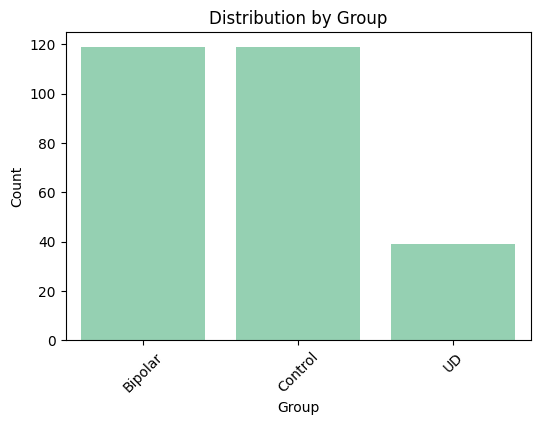

In [20]:
plot_dist(df, 'Group')

In [21]:
df_group = df.drop(columns=['Type'])
df_group.head()

,Group,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,Bipolar,47,40,9,11,9,11,18,22,23,17
1,Bipolar,49,49,13,13,11,12,24,25,24,25
2,Bipolar,45,43,9,11,13,10,21,22,24,19
3,Bipolar,53,44,10,10,12,12,25,19,24,20
4,Bipolar,50,50,14,13,11,12,23,27,23,27


### Correlation matrix

In [22]:
df_group_encoded = df_group.copy()

# Label encoding
label_encoder = LabelEncoder()
df_group_encoded['Group'] = label_encoder.fit_transform(df_group_encoded['Group'])

df_group_encoded.head()

,Group,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,0,47,40,9,11,9,11,18,22,23,17
1,0,49,49,13,13,11,12,24,25,24,25
2,0,45,43,9,11,13,10,21,22,24,19
3,0,53,44,10,10,12,12,25,19,24,20
4,0,50,50,14,13,11,12,23,27,23,27


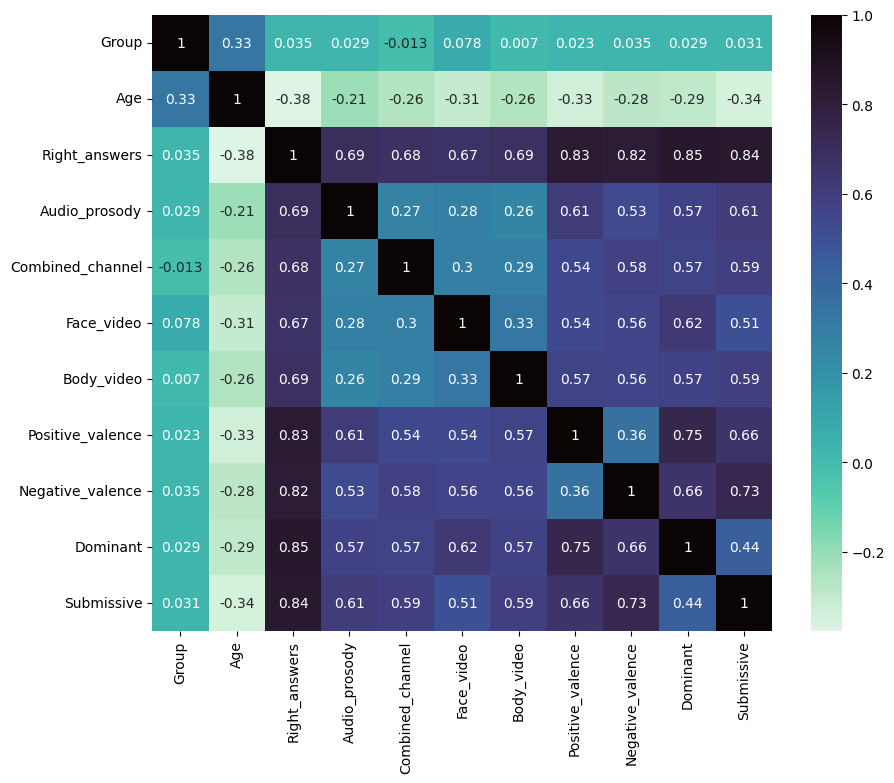

In [23]:
corr_mtx_group = df_group_encoded.corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_mtx_group, cmap='mako_r', annot=True, ax=ax)
plt.show()

## By `Type`

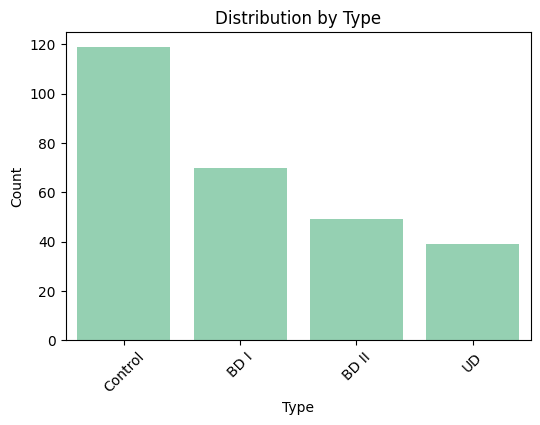

In [24]:
plot_dist(df, 'Type')

In [25]:
df_type = df.drop(columns=['Group'])
df_type.head()

,Type,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,BD I,47,40,9,11,9,11,18,22,23,17
1,BD I,49,49,13,13,11,12,24,25,24,25
2,BD I,45,43,9,11,13,10,21,22,24,19
3,BD I,53,44,10,10,12,12,25,19,24,20
4,BD II,50,50,14,13,11,12,23,27,23,27


### Correlation matrix

In [26]:
df_type_encoded = df_type.copy()

# Label encoding
label_encoder = LabelEncoder()
df_type_encoded['Type'] = label_encoder.fit_transform(df_type_encoded['Type'])

df_type_encoded.head()

,Type,Age,Right_answers,Audio_prosody,Combined_channel,Face_video,Body_video,Positive_valence,Negative_valence,Dominant,Submissive
0,0,47,40,9,11,9,11,18,22,23,17
1,0,49,49,13,13,11,12,24,25,24,25
2,0,45,43,9,11,13,10,21,22,24,19
3,0,53,44,10,10,12,12,25,19,24,20
4,1,50,50,14,13,11,12,23,27,23,27


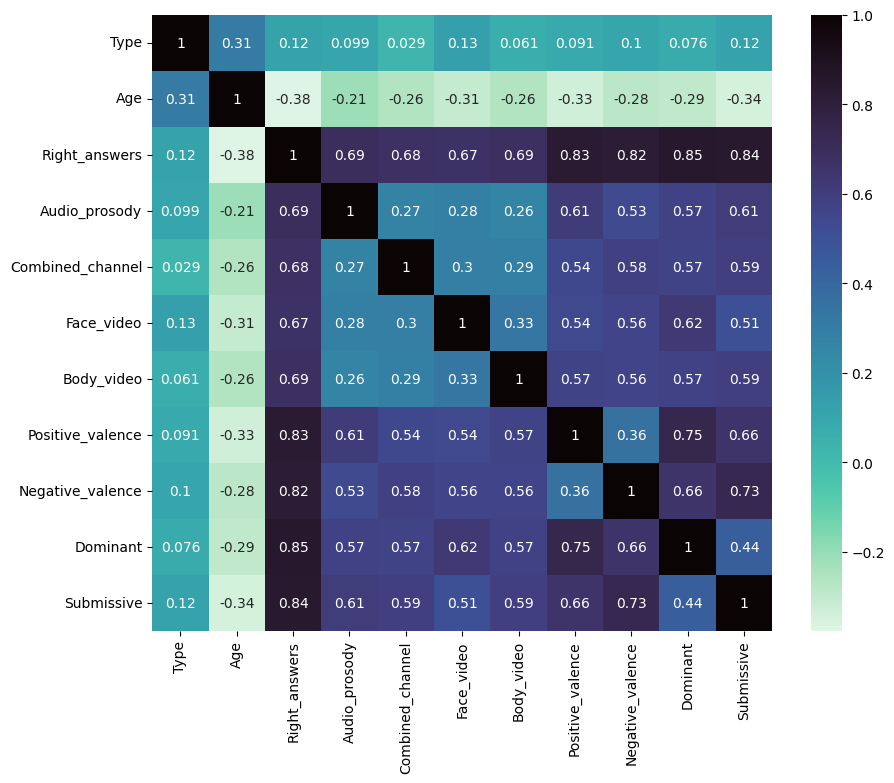

In [27]:
corr_mtx_type = df_type_encoded.corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_mtx_type, cmap='mako_r', annot=True, ax=ax)
plt.show()

# Data Analysis

## Feature distribution

### By `Group`

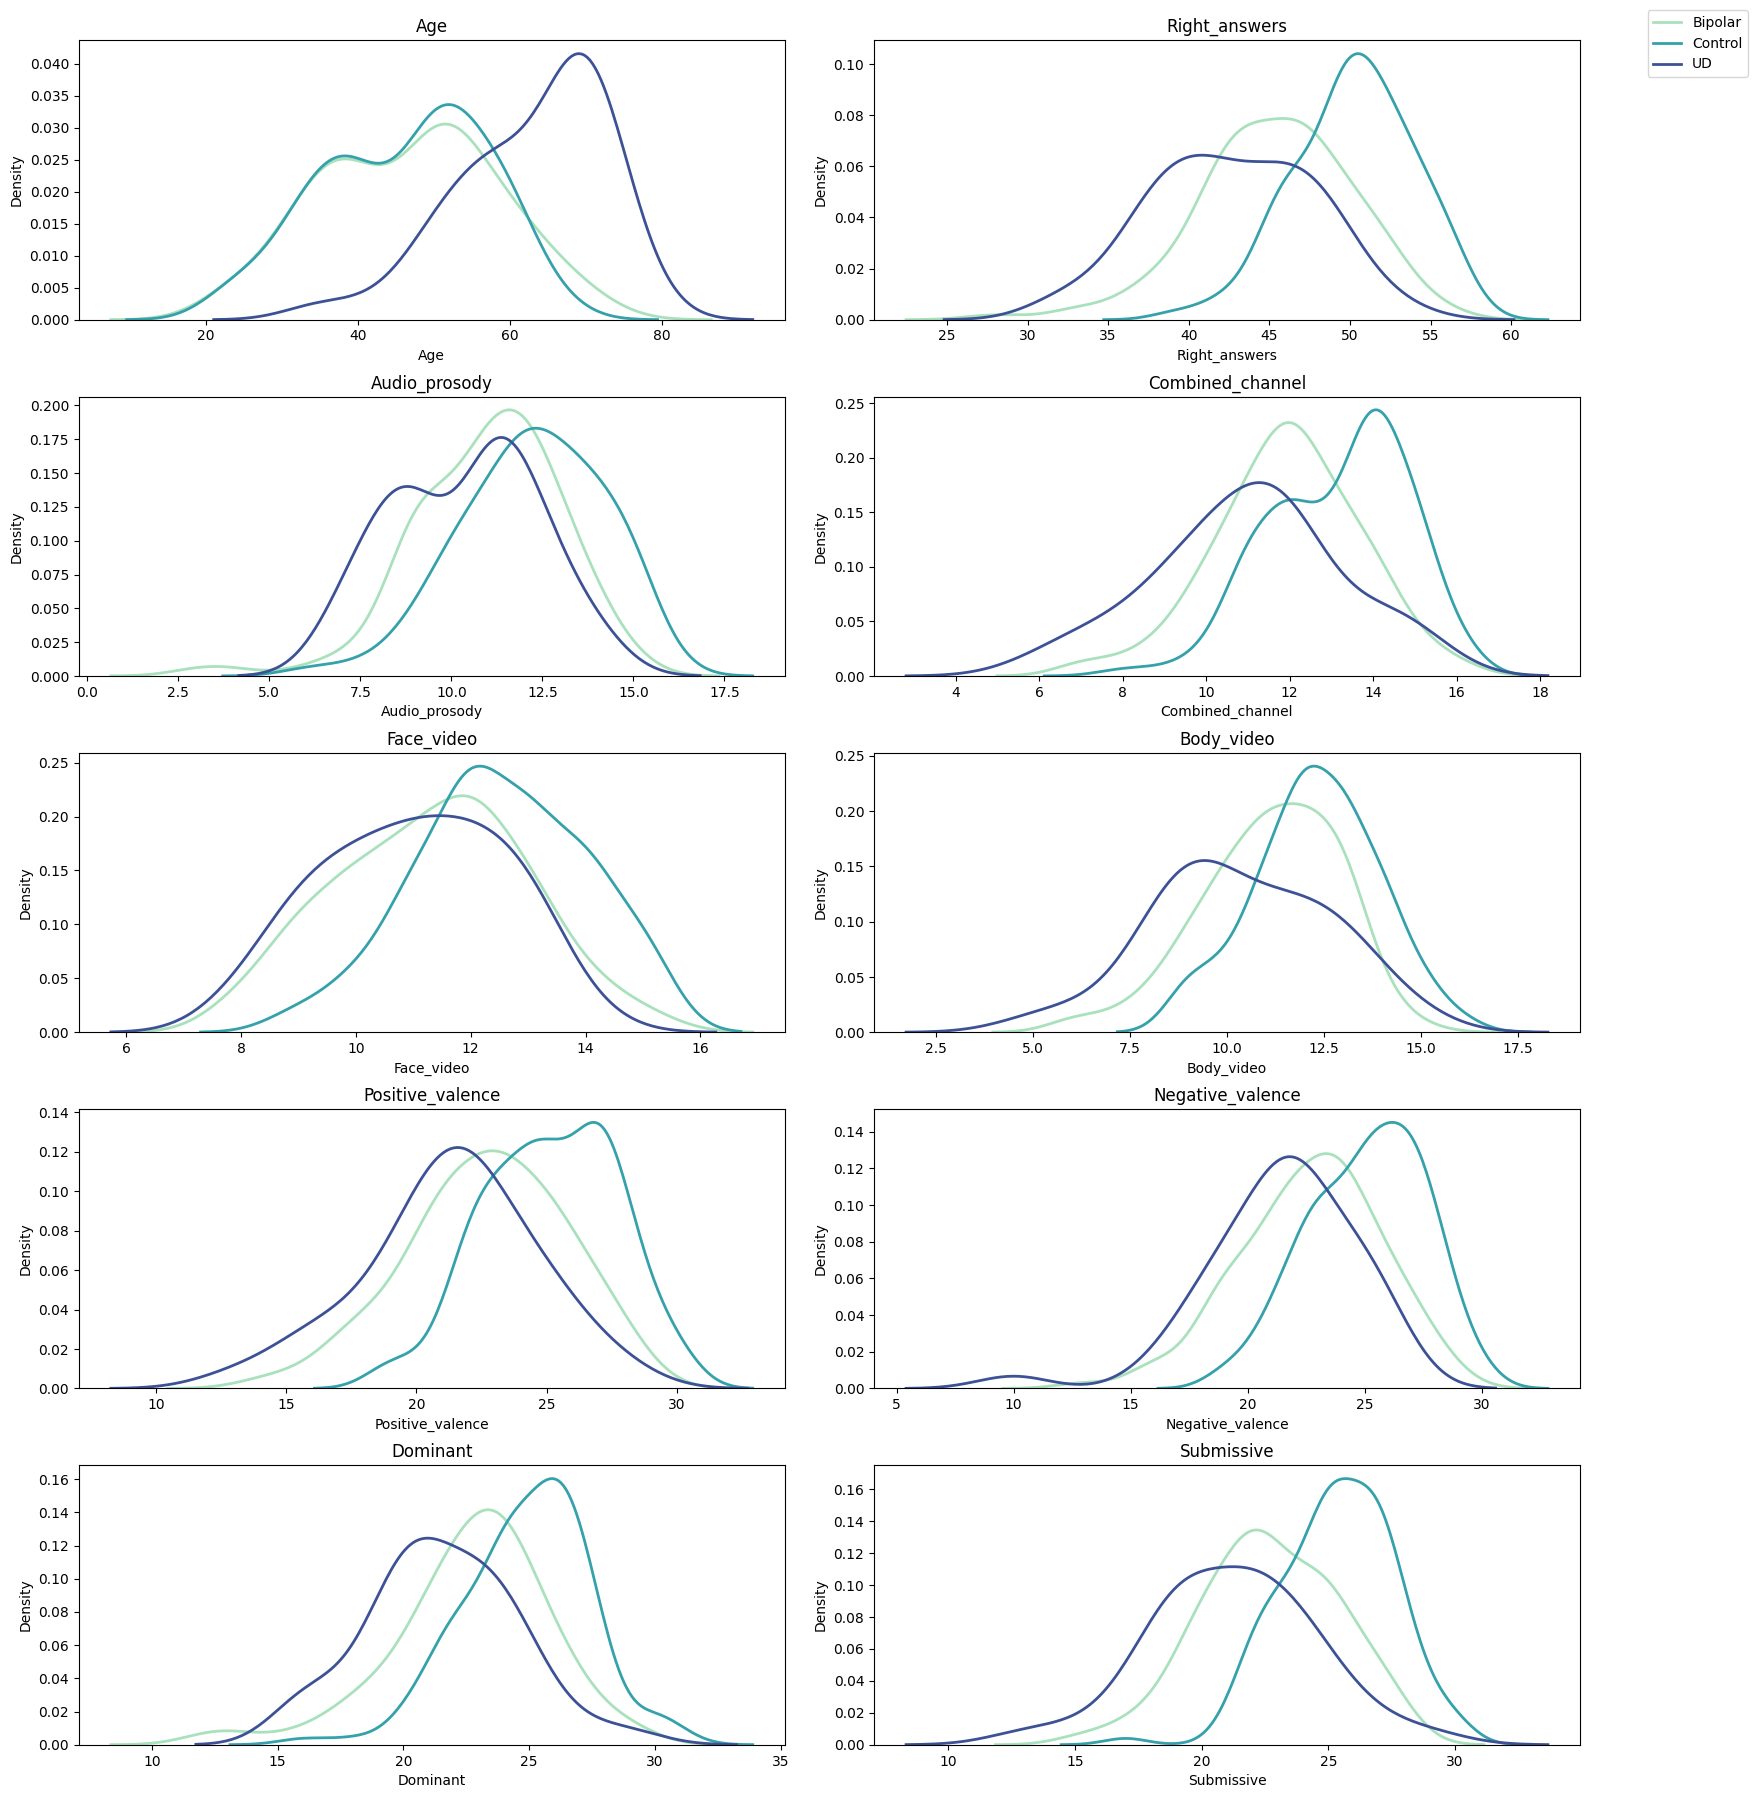

In [28]:
X_group = df_group_encoded.drop(columns=['Group'])
y_group = df_group['Group']

plot_feature_dist(X_group, y_group, 'Group')

### By `Type`

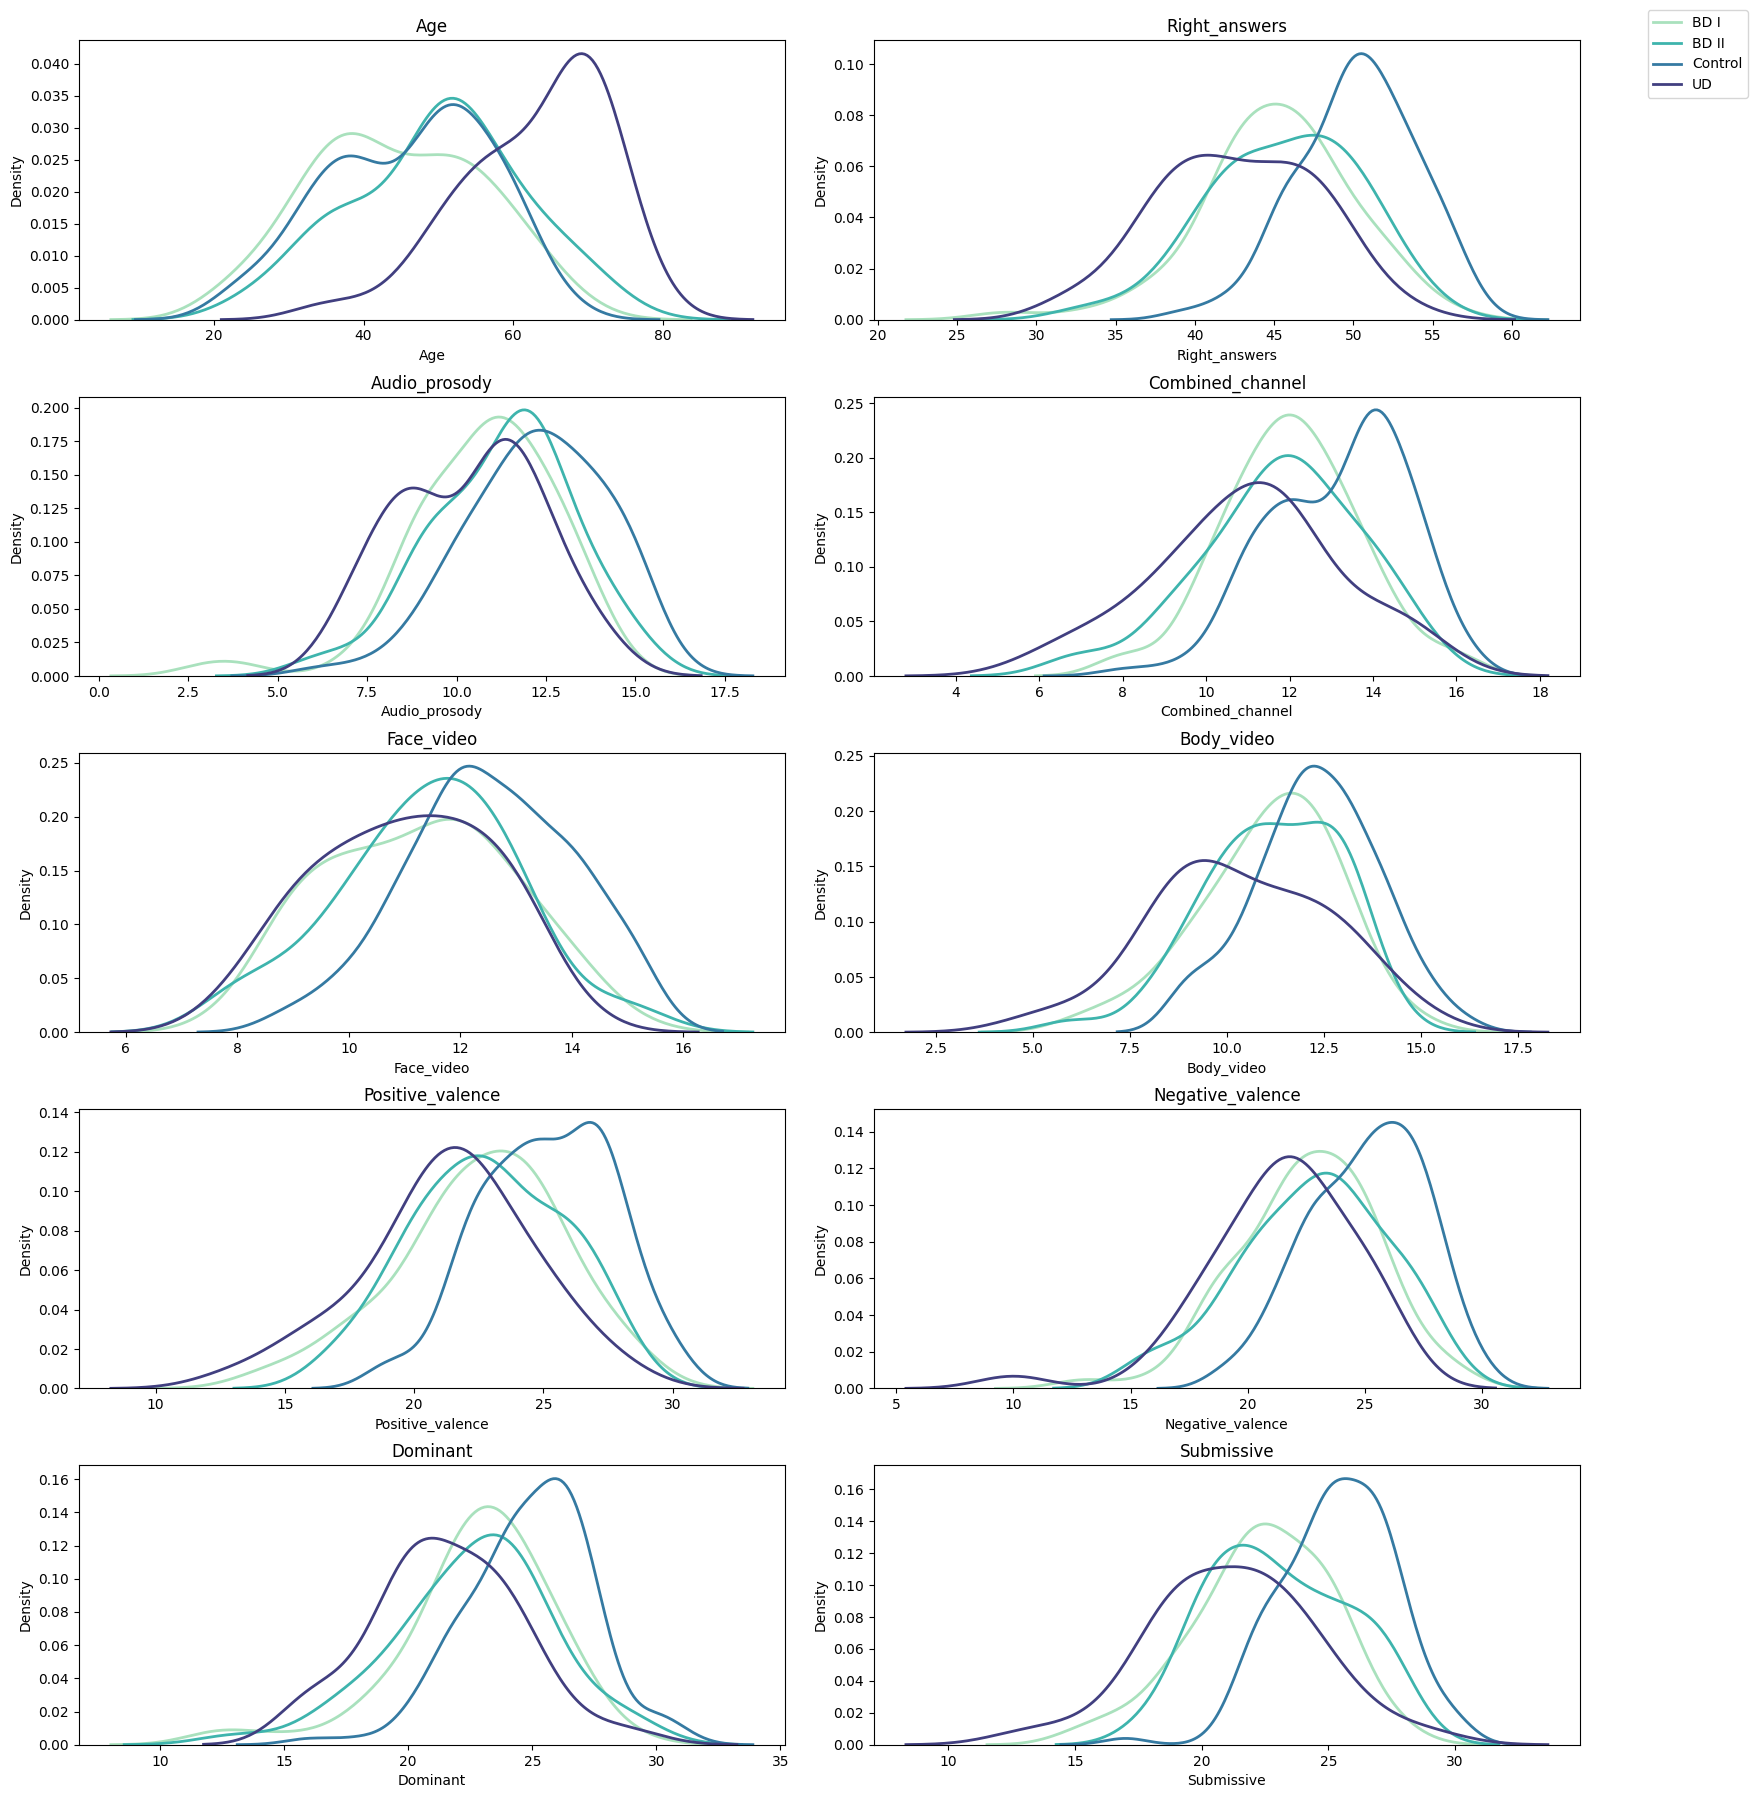

In [29]:
X_type = df_type_encoded.drop(columns=['Type'])
y_type = df_type['Type']

plot_feature_dist(X_type, y_type, 'Type')

## ANOVA (F-test)

In [30]:
anova_group = run_anova(X_group, y_group)
anova_group

[('Right_answers', np.float64(4.0167443904323985e-22)),
 ('Submissive', np.float64(1.061582075984475e-19)),
 ('Age', np.float64(4.279339999803681e-15)),
 ('Positive_valence', np.float64(1.9215966210154366e-14)),
 ('Negative_valence', np.float64(2.5018637650584064e-14)),
 ('Dominant', np.float64(7.627397216074451e-12)),
 ('Combined_channel', np.float64(1.3033498210739661e-11)),
 ('Face_video', np.float64(3.883673471941072e-10)),
 ('Body_video', np.float64(6.180814486122786e-10)),
 ('Audio_prosody', np.float64(4.234110537071591e-08))]

In [31]:
anova_type = run_anova(X_type, y_type)
anova_type

[('Right_answers', np.float64(2.904653065594693e-21)),
 ('Submissive', np.float64(3.2435787477820166e-19)),
 ('Age', np.float64(9.96265733207646e-16)),
 ('Positive_valence', np.float64(1.1558806715111282e-13)),
 ('Negative_valence', np.float64(1.5337166414326735e-13)),
 ('Dominant', np.float64(4.4194763750376015e-11)),
 ('Combined_channel', np.float64(5.967576635509073e-11)),
 ('Face_video', np.float64(1.9046160174620614e-09)),
 ('Body_video', np.float64(3.3238042580692537e-09)),
 ('Audio_prosody', np.float64(7.846232052934526e-08))]

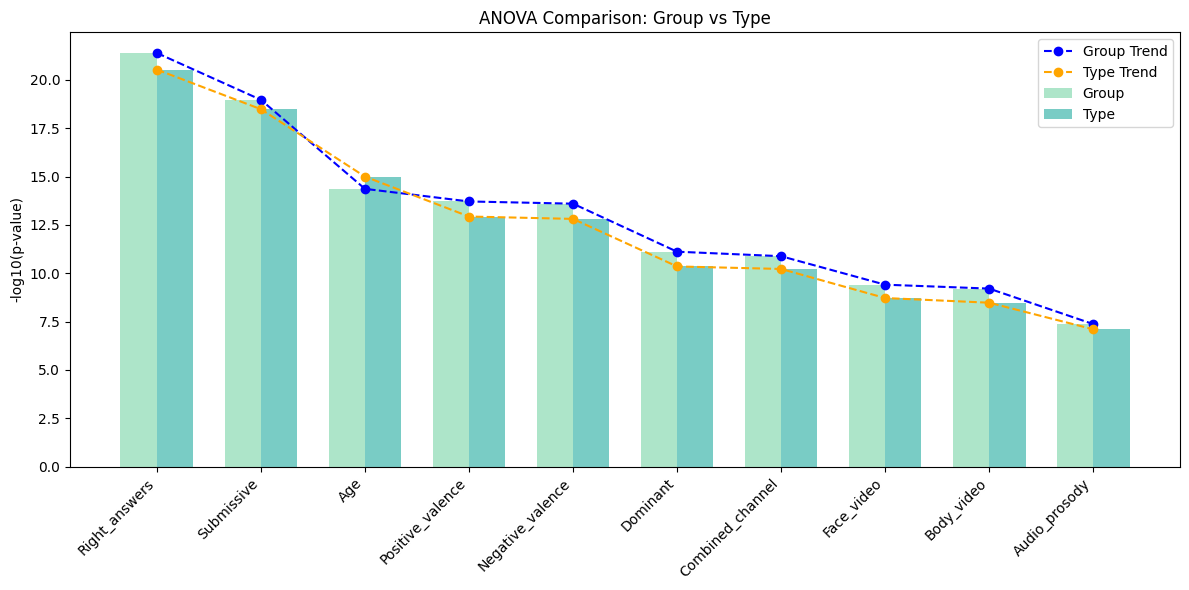

In [32]:
# Convert to DataFrames and compute -log10(p-values) for plotting
anova_group_df = pd.DataFrame(anova_group, columns=['Feature', 'p_group'])
anova_type_df = pd.DataFrame(anova_type, columns=['Feature', 'p_type'])

# Merge on feature names
anova_df = pd.merge(anova_group_df, anova_type_df, on='Feature')

# Transform p-values to -log10 for better visualization (smaller p -> bigger bar)
anova_df['group_score'] = -np.log10(anova_df['p_group'])
anova_df['type_score'] = -np.log10(anova_df['p_type'])

# Sort by mean score
anova_df['mean_score'] = anova_df[['group_score', 'type_score']].mean(axis=1)
anova_df = anova_df.sort_values('mean_score', ascending=False)

# Plot
x = np.arange(len(anova_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, anova_df['group_score'], width, label='Group', alpha=0.7)
ax.bar(x + width/2, anova_df['type_score'], width, label='Type', alpha=0.7)

# Trend lines
ax.plot(x, anova_df['group_score'], color='blue', linestyle='--', marker='o', label='Group Trend')
ax.plot(x, anova_df['type_score'], color='orange', linestyle='--', marker='o', label='Type Trend')

ax.set_xticks(x)
ax.set_xticklabels(anova_df['Feature'], rotation=45, ha='right')
ax.set_ylabel('-log10(p-value)')
ax.set_title('ANOVA Comparison: Group vs Type')
ax.legend()
plt.tight_layout()
plt.show()

## Mutual information

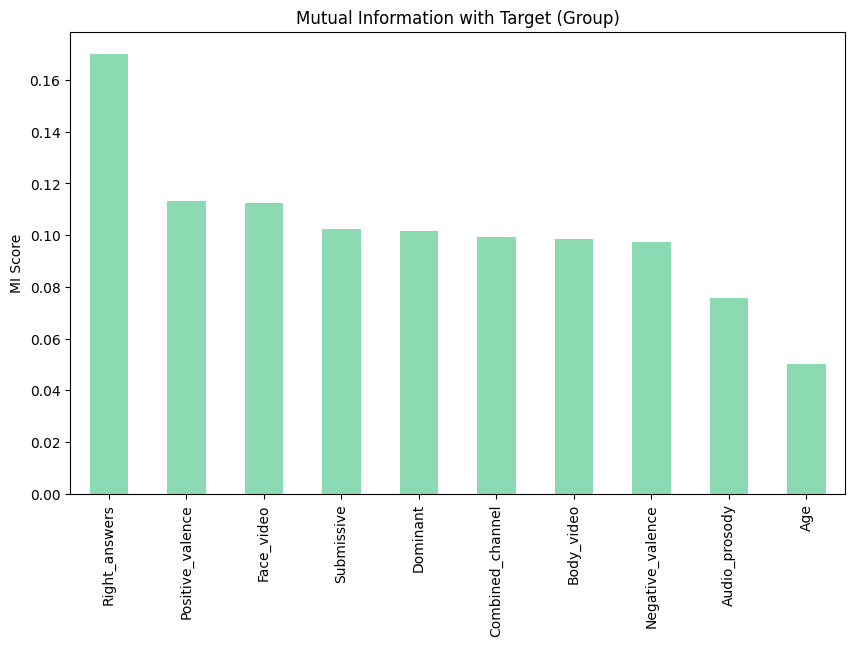

In [33]:
mi_group = compute_mutual_info(X_group, y_group, title="Group")

In [34]:
print(mi_group)

Right_answers       0.170146
Positive_valence    0.113194
Face_video          0.112402
Submissive          0.102513
Dominant            0.101641
Combined_channel    0.099370
Body_video          0.098499
Negative_valence    0.097393
Audio_prosody       0.075786
Age                 0.050046
dtype: float64


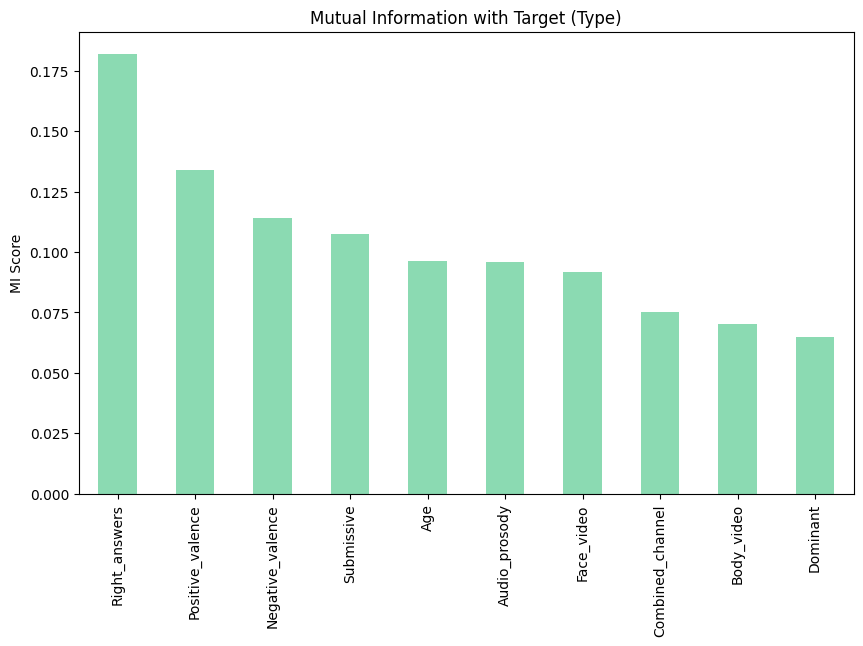

In [35]:
mi_type = compute_mutual_info(X_type, y_type, title="Type")

In [36]:
print(mi_type)

Right_answers       0.182000
Positive_valence    0.134084
Negative_valence    0.114247
Submissive          0.107602
Age                 0.096492
Audio_prosody       0.095691
Face_video          0.091706
Combined_channel    0.075188
Body_video          0.070278
Dominant            0.064656
dtype: float64


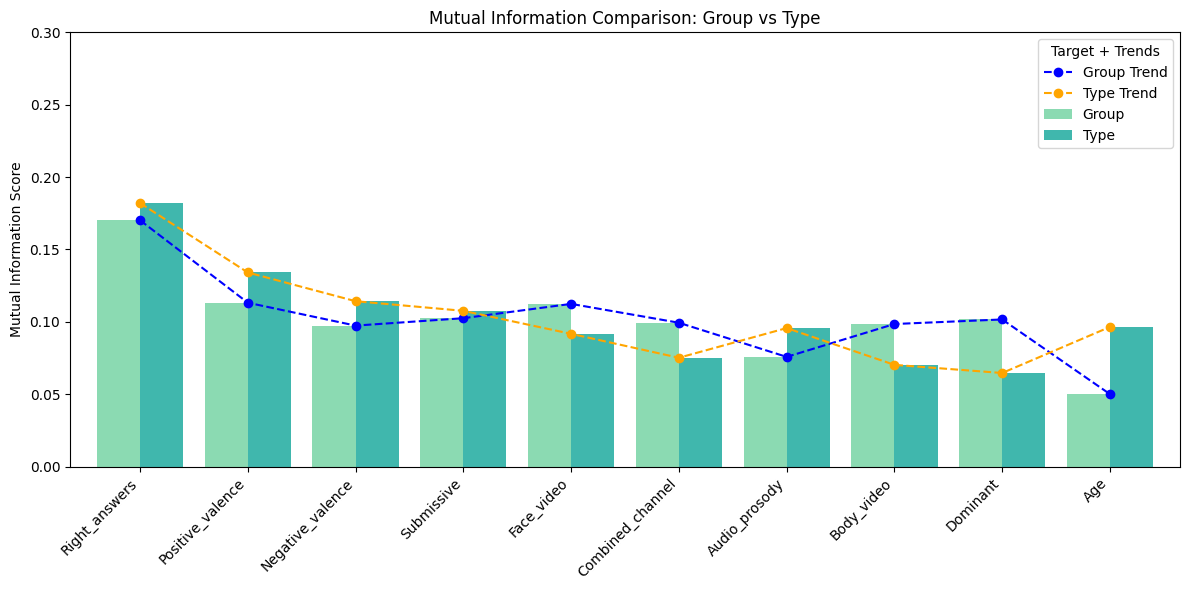

In [37]:
# Combine the two MI Series into one DataFrame
mi_df = pd.DataFrame({
    'Group': mi_group,
    'Type': mi_type
})

# Combine and sort by mean
mi_df = pd.DataFrame({
    'Group': mi_group,
    'Type': mi_type
})
mi_df['mean'] = mi_df.mean(axis=1)
mi_df = mi_df.sort_values('mean', ascending=False).drop(columns='mean')

# Plot bar chart
ax = mi_df.plot(kind='bar', figsize=(12, 6), width=0.8)

# Trends
x = np.arange(len(mi_df))
ax.plot(x, mi_df['Group'].values, color='blue', linestyle='--', marker='o', label='Group Trend')
ax.plot(x, mi_df['Type'].values, color='orange', linestyle='--', marker='o', label='Type Trend')

plt.title("Mutual Information Comparison: Group vs Type")
plt.ylabel("Mutual Information Score")
plt.ylim(0, 0.3)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Target + Trends')
plt.tight_layout()
plt.show()

# Modeling by `Group`

## Tree-based methods

### Data preparation

In [38]:
X, y = data_prep(df_group, target='group', scale=False)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [39]:
data_splits["dt_group_shallow"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["dt_group_deep"] = data_splits["dt_group_shallow"].copy()
data_splits["rf_group"] = data_splits["dt_group_shallow"].copy()

### Decision Tree

#### Shallow DT

In [40]:
dt_group_shallow = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [41]:
evaluate_and_save(dt_group_shallow, model_name="dt_group_shallow")

=== dt_group_shallow ===
              precision    recall  f1-score   support

     Bipolar       0.42      0.44      0.43        18
     Control       0.62      0.57      0.59        14
          UD       0.50      0.50      0.50        10

    accuracy                           0.50        42
   macro avg       0.51      0.51      0.51        42
weighted avg       0.50      0.50      0.50        42

Accuracy: 0.5000



#### Deep DT

In [42]:
dt_group_deep = DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,
    random_state=42
)

In [43]:
evaluate_and_save(dt_group_deep, model_name="dt_group_deep")

=== dt_group_deep ===
              precision    recall  f1-score   support

     Bipolar       0.50      0.56      0.53        18
     Control       0.77      0.71      0.74        14
          UD       0.44      0.40      0.42        10

    accuracy                           0.57        42
   macro avg       0.57      0.56      0.56        42
weighted avg       0.58      0.57      0.57        42

Accuracy: 0.5714



### Decision Tree with feature selection

#### ANOVA

##### 5 features

In [44]:
X_selected = select_features(df_group, num_features=5, target='group', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 5 features (anova) for target 'group':
1: Age
2: Right_answers
3: Positive_valence
4: Negative_valence
5: Submissive


In [45]:
data_splits["dt_group_anova_5"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_group_anova_5"] = data_splits["dt_group_anova_5"].copy()

In [46]:
dt_group_anova_5 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [47]:
evaluate_and_save(dt_group_anova_5, model_name="dt_group_anova_5")

=== dt_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.55      0.67      0.60        18
     Control       0.62      0.57      0.59        14
          UD       0.86      0.60      0.71        10

    accuracy                           0.62        42
   macro avg       0.67      0.61      0.63        42
weighted avg       0.64      0.62      0.62        42

Accuracy: 0.6190



##### 7 features

In [48]:
X_selected = select_features(df_group, num_features=7, target='group', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 7 features (anova) for target 'group':
1: Age
2: Right_answers
3: Combined_channel
4: Positive_valence
5: Negative_valence
6: Dominant
7: Submissive


In [49]:
data_splits["dt_group_anova_7"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_group_anova_7"] = data_splits["dt_group_anova_7"].copy()

In [50]:
dt_group_anova_7 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [51]:
evaluate_and_save(dt_group_anova_7, model_name="dt_group_anova_7")

=== dt_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.44      0.44      0.44        18
     Control       0.57      0.57      0.57        14
          UD       0.50      0.50      0.50        10

    accuracy                           0.50        42
   macro avg       0.51      0.51      0.51        42
weighted avg       0.50      0.50      0.50        42

Accuracy: 0.5000



#### Mutual Information

In [52]:
X_selected = select_features(df_group, num_features=6, target='group', method='mi')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 6 features (mi) for target 'group':
1: Right_answers
2: Combined_channel
3: Face_video
4: Negative_valence
5: Dominant
6: Submissive


In [53]:
data_splits["dt_group_mi_6"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_group_mi_6"] = data_splits["dt_group_mi_6"].copy()

In [54]:
dt_group_mi_6 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [55]:
evaluate_and_save(dt_group_mi_6, model_name="dt_group_mi_6")

=== dt_group_mi_6 ===
              precision    recall  f1-score   support

     Bipolar       0.55      0.67      0.60        18
     Control       0.56      0.64      0.60        14
          UD       0.75      0.30      0.43        10

    accuracy                           0.57        42
   macro avg       0.62      0.54      0.54        42
weighted avg       0.60      0.57      0.56        42

Accuracy: 0.5714



### Random Forest

In [56]:
rf_group = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [57]:
evaluate_and_save(rf_group, model_name="rf_group")

=== rf_group ===
              precision    recall  f1-score   support

     Bipolar       0.50      0.61      0.55        18
     Control       0.56      0.64      0.60        14
          UD       0.50      0.20      0.29        10

    accuracy                           0.52        42
   macro avg       0.52      0.48      0.48        42
weighted avg       0.52      0.52      0.50        42

Accuracy: 0.5238



### Random Forest with feature selection

#### ANOVA

##### 5 features

In [58]:
rf_group_anova_5 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [59]:
evaluate_and_save(rf_group_anova_5, model_name="rf_group_anova_5")

=== rf_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.65      0.72      0.68        18
     Control       0.65      0.79      0.71        14
          UD       0.80      0.40      0.53        10

    accuracy                           0.67        42
   macro avg       0.70      0.64      0.64        42
weighted avg       0.68      0.67      0.66        42

Accuracy: 0.6667



##### 7 features

In [60]:
rf_group_anova_7 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [61]:
evaluate_and_save(rf_group_anova_7, model_name="rf_group_anova_7")

=== rf_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.59      0.72      0.65        18
     Control       0.62      0.71      0.67        14
          UD       0.75      0.30      0.43        10

    accuracy                           0.62        42
   macro avg       0.66      0.58      0.58        42
weighted avg       0.64      0.62      0.60        42

Accuracy: 0.6190



#### Mutual Information

In [62]:
rf_group_mi_6 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [63]:
evaluate_and_save(rf_group_mi_6, model_name="rf_group_mi_6")

=== rf_group_mi_6 ===
              precision    recall  f1-score   support

     Bipolar       0.47      0.50      0.49        18
     Control       0.55      0.79      0.65        14
          UD       0.33      0.10      0.15        10

    accuracy                           0.50        42
   macro avg       0.45      0.46      0.43        42
weighted avg       0.47      0.50      0.46        42

Accuracy: 0.5000



## SVM

### Data preparation

In [64]:
X, y = data_prep(df_group, target='group', scale=True)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [65]:
data_splits["poly_group"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["poly_group_grid"] = data_splits["poly_group"].copy()

data_splits["rbf_group"] = data_splits["poly_group"].copy()
data_splits["rbf_group_grid"] = data_splits["poly_group"].copy()

### Polynomial kernel

In [66]:
poly_group = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [67]:
evaluate_and_save(poly_group, model_name="poly_group")

=== poly_group ===
              precision    recall  f1-score   support

     Bipolar       0.46      0.67      0.55        18
     Control       0.46      0.43      0.44        14
          UD       0.67      0.20      0.31        10

    accuracy                           0.48        42
   macro avg       0.53      0.43      0.43        42
weighted avg       0.51      0.48      0.46        42

Accuracy: 0.4762



#### Polynomial kernel with GridSearchCV

In [68]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["poly"]
}

grid_poly = GridSearchCV(SVC(class_weight="balanced"), param_grid, cv=5, scoring="f1_macro")
grid_poly.fit(X_train, y_train)

print("Best parameters:", grid_poly.best_params_)

Best parameters: {'C': 0.1, 'kernel': 'poly'}


In [69]:
poly_group_grid = svm.SVC(kernel='poly', degree=3, C=10, class_weight="balanced").fit(X_train, y_train)

In [70]:
evaluate_and_save(poly_group_grid, model_name="poly_group_grid")

=== poly_group_grid ===
              precision    recall  f1-score   support

     Bipolar       0.55      0.61      0.58        18
     Control       0.50      0.57      0.53        14
          UD       0.67      0.40      0.50        10

    accuracy                           0.55        42
   macro avg       0.57      0.53      0.54        42
weighted avg       0.56      0.55      0.54        42

Accuracy: 0.5476



### RBF kernel

In [71]:
rbf_group = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)

In [72]:
evaluate_and_save(rbf_group, model_name="rbf_group")

=== rbf_group ===
              precision    recall  f1-score   support

     Bipolar       0.48      0.72      0.58        18
     Control       0.60      0.64      0.62        14
          UD       0.00      0.00      0.00        10

    accuracy                           0.52        42
   macro avg       0.36      0.46      0.40        42
weighted avg       0.41      0.52      0.45        42

Accuracy: 0.5238



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### RBF kernel with GridSearchCV

In [73]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
    "kernel": ["rbf"]
}

grid_rbf = GridSearchCV(SVC(class_weight="balanced"), param_grid, cv=5, scoring="f1_macro")
grid_rbf.fit(X_train, y_train)

print("Best parameters:", grid_rbf.best_params_)

Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [74]:
rbf_group_grid = svm.SVC(kernel='rbf', gamma=10, C=1, class_weight="balanced").fit(X_train, y_train)

In [75]:
evaluate_and_save(rbf_group_grid, model_name="rbf_group_grid")

=== rbf_group_grid ===
              precision    recall  f1-score   support

     Bipolar       0.47      0.50      0.49        18
     Control       0.50      0.64      0.56        14
          UD       0.60      0.30      0.40        10

    accuracy                           0.50        42
   macro avg       0.52      0.48      0.48        42
weighted avg       0.51      0.50      0.49        42

Accuracy: 0.5000



## SVM with feature selection

### ANOVA

#### 5 features

In [76]:
X_selected = select_features(df_group, num_features=5, target='group', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 5 features (anova) for target 'group':
1: Age
2: Right_answers
3: Positive_valence
4: Negative_valence
5: Submissive


In [77]:
data_splits["poly_group_anova_5"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_group_anova_5"] = data_splits["poly_group_anova_5"].copy()

##### Polynomial kernel

In [78]:
poly_group_anova_5 = svm.SVC(kernel='poly', degree=3, C=1, class_weight="balanced").fit(X_train, y_train)

In [79]:
evaluate_and_save(poly_group_anova_5, model_name="poly_group_anova_5")

=== poly_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.50      0.56      0.53        18
     Control       0.40      0.29      0.33        14
          UD       0.50      0.60      0.55        10

    accuracy                           0.48        42
   macro avg       0.47      0.48      0.47        42
weighted avg       0.47      0.48      0.47        42

Accuracy: 0.4762



##### RBF kernel

In [80]:
rbf_group_anova_5 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [81]:
evaluate_and_save(rbf_group_anova_5, model_name="rbf_group_anova_5")

=== rbf_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.57      0.22      0.32        18
     Control       0.57      0.86      0.69        14
          UD       0.57      0.80      0.67        10

    accuracy                           0.57        42
   macro avg       0.57      0.63      0.56        42
weighted avg       0.57      0.57      0.52        42

Accuracy: 0.5714



#### 7 features

In [82]:
X_selected = select_features(df_group, num_features=7, target='group', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 7 features (anova) for target 'group':
1: Age
2: Right_answers
3: Combined_channel
4: Positive_valence
5: Negative_valence
6: Dominant
7: Submissive


In [83]:
data_splits["poly_group_anova_7"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_group_anova_7"] = data_splits["poly_group_anova_7"].copy()

##### Polynomial kernel

In [84]:
poly_group_anova_7 = svm.SVC(kernel='poly', degree=3, C=1, class_weight="balanced").fit(X_train, y_train)

In [85]:
evaluate_and_save(poly_group_anova_7, model_name="poly_group_anova_7")

=== poly_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.44      0.61      0.51        18
     Control       0.50      0.36      0.42        14
          UD       0.71      0.50      0.59        10

    accuracy                           0.50        42
   macro avg       0.55      0.49      0.51        42
weighted avg       0.53      0.50      0.50        42

Accuracy: 0.5000



##### RBF kernel

In [86]:
rbf_group_anova_7 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [87]:
evaluate_and_save(rbf_group_anova_7, model_name="rbf_group_anova_7")

=== rbf_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.53      0.44      0.48        18
     Control       0.64      0.64      0.64        14
          UD       0.62      0.80      0.70        10

    accuracy                           0.60        42
   macro avg       0.60      0.63      0.61        42
weighted avg       0.59      0.60      0.59        42

Accuracy: 0.5952



### Mutual information

In [88]:
X_selected = select_features(df_group, num_features=6, target='group', method='mi')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 6 features (mi) for target 'group':
1: Right_answers
2: Face_video
3: Body_video
4: Positive_valence
5: Dominant
6: Submissive


In [89]:
data_splits["poly_group_mi_6"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_group_mi_6"] = data_splits["poly_group_mi_6"].copy()

#### Polynomial kernel

In [90]:
poly_group_mi_6 = svm.SVC(kernel='poly', degree=3, C=1, class_weight="balanced").fit(X_train, y_train)

In [91]:
evaluate_and_save(poly_group_mi_6, model_name="poly_group_mi_6")

=== poly_group_mi_6 ===
              precision    recall  f1-score   support

     Bipolar       0.42      0.28      0.33        18
     Control       0.50      0.50      0.50        14
          UD       0.38      0.60      0.46        10

    accuracy                           0.43        42
   macro avg       0.43      0.46      0.43        42
weighted avg       0.43      0.43      0.42        42

Accuracy: 0.4286



#### RBF kernel

In [92]:
rbf_group_mi_6 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [93]:
evaluate_and_save(rbf_group_mi_6, model_name="rbf_group_mi_6")

=== rbf_group_mi_6 ===
              precision    recall  f1-score   support

     Bipolar       0.43      0.56      0.49        18
     Control       0.58      0.79      0.67        14
          UD       0.00      0.00      0.00        10

    accuracy                           0.50        42
   macro avg       0.34      0.45      0.38        42
weighted avg       0.38      0.50      0.43        42

Accuracy: 0.5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## Neural Networks

### Data preparation

In [94]:
X, y_raw = data_prep(df_group, target='group', scale=True)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names_group = label_encoder.classes_

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [95]:
data_splits["model_group"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["model_group_reg"] = data_splits["model_group"].copy()
data_splits["model_group_dl"] = data_splits["model_group"].copy()

### Basic neural network

In [96]:
model_group = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(set(y)), activation='softmax')
])

model_group.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [97]:
history_model_group = model_group.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=50,
                                batch_size=32,
                                verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.4591 - loss: 1.0643 - val_accuracy: 0.4048 - val_loss: 1.0402
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4352 - loss: 1.0126 - val_accuracy: 0.4286 - val_loss: 1.0284
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5012 - loss: 0.9659 - val_accuracy: 0.4286 - val_loss: 1.0291
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5221 - loss: 0.9340 - val_accuracy: 0.4524 - val_loss: 1.0313
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5014 - loss: 0.9488 - val_accuracy: 0.4524 - val_loss: 1.0276
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5396 - loss: 0.9048 - val_accuracy: 0.4762 - val_loss: 1.0236
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5534 - loss: 0.8970 - val_accuracy: 0.4762 - val_loss: 1.0097
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5388 - loss: 0.8879 - val_accuracy: 0.4762 - val_loss: 0.9935

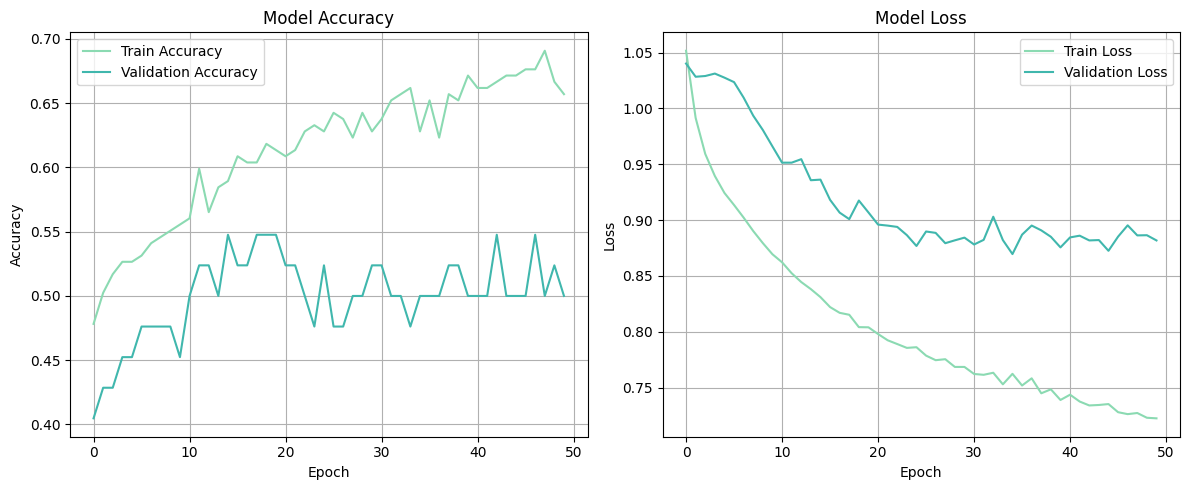

In [98]:
plot_hist(history_model_group)

=== model_group ===
              precision    recall  f1-score   support

           0       0.41      0.39      0.40        18
           1       0.53      0.64      0.58        14
           2       0.62      0.50      0.56        10

    accuracy                           0.50        42
   macro avg       0.52      0.51      0.51        42
weighted avg       0.50      0.50      0.50        42

Accuracy: 0.5000



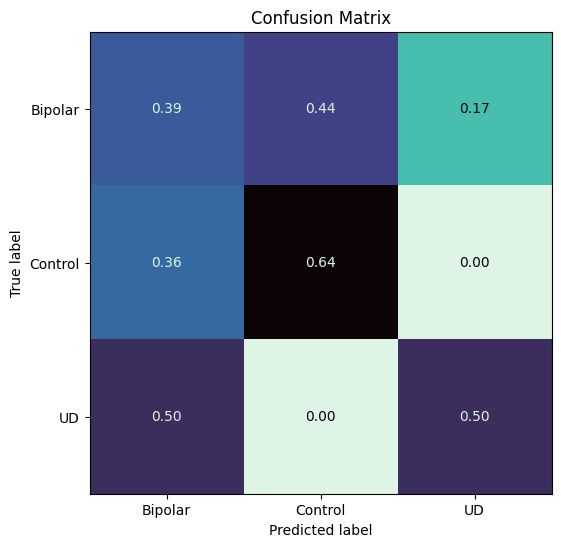

In [99]:
save_nn_history(history_model_group, model_name="model_group", class_names=class_names_group)

### Neural network with regularization and early stopping

In [100]:
model_group_reg = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(len(set(y)), activation='softmax')
])

model_group_reg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [101]:
history_model_group_reg = model_group_reg.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.4401 - loss: 1.0947 - val_accuracy: 0.4048 - val_loss: 1.1004
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4559 - loss: 1.0164 - val_accuracy: 0.3333 - val_loss: 1.0976
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4570 - loss: 1.0048 - val_accuracy: 0.3333 - val_loss: 1.1043
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4401 - loss: 0.9918 - val_accuracy: 0.3333 - val_loss: 1.1039
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5035 - loss: 0.9671 - val_accuracy: 0.4048 - val_loss: 1.0964
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4925 - loss: 0.9580 - val_accuracy: 0.5000 - val_loss: 1.0798
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5483 - loss: 0.9823 - val_accuracy: 0.5000 - val_loss: 1.0675
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5466 - loss: 0.9686 - val_accuracy: 0.4762 - val_loss

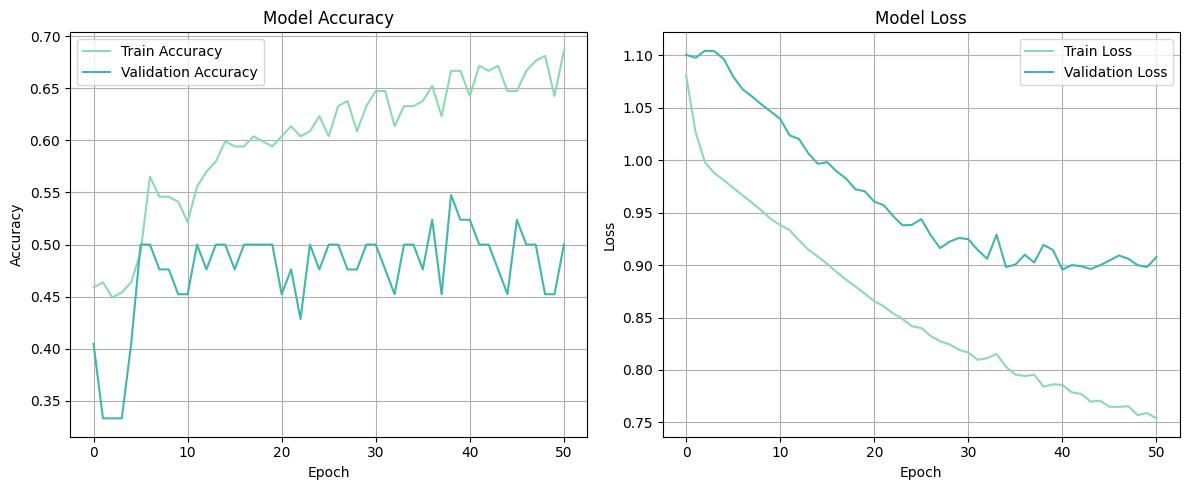

In [102]:
plot_hist(history_model_group_reg)

=== model_group_reg ===
              precision    recall  f1-score   support

           0       0.44      0.39      0.41        18
           1       0.59      0.71      0.65        14
           2       0.56      0.50      0.53        10

    accuracy                           0.52        42
   macro avg       0.53      0.53      0.53        42
weighted avg       0.52      0.52      0.52        42

Accuracy: 0.5238



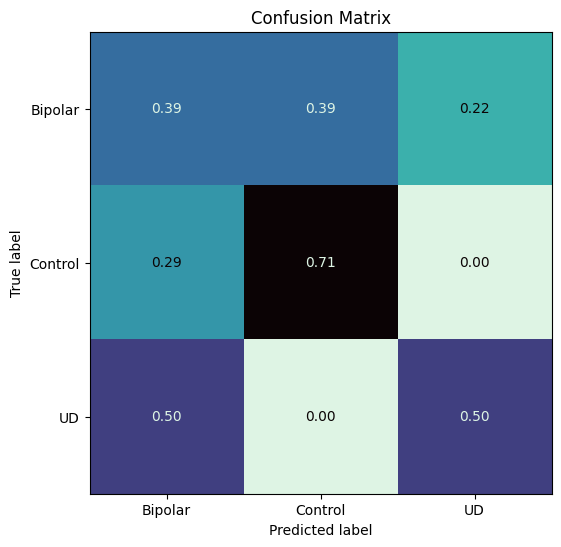

In [103]:
save_nn_history(history_model_group_reg, model_name="model_group_reg", class_names=class_names_group)

### Deep learning model

In [104]:
model_group_dl = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(len(set(y)), activation='softmax')
])

model_group_dl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [105]:
history_model_group_dl = model_group_dl.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.3719 - loss: 1.2029 - val_accuracy: 0.3333 - val_loss: 1.1807
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4603 - loss: 1.1054 - val_accuracy: 0.3333 - val_loss: 1.1729
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4210 - loss: 1.0905 - val_accuracy: 0.3333 - val_loss: 1.1669
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4400 - loss: 1.0498 - val_accuracy: 0.3333 - val_loss: 1.1674
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4646 - loss: 1.0251 - val_accuracy: 0.3333 - val_loss: 1.1487
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4375 - loss: 1.0302 - val_accuracy: 0.4048 - val_loss: 1.1069
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4900 - loss: 1.0289 - val_accuracy: 0.4286 - val_loss: 1.0926
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4974 - loss: 1.0038 - val_accuracy: 0.4762 - val_loss

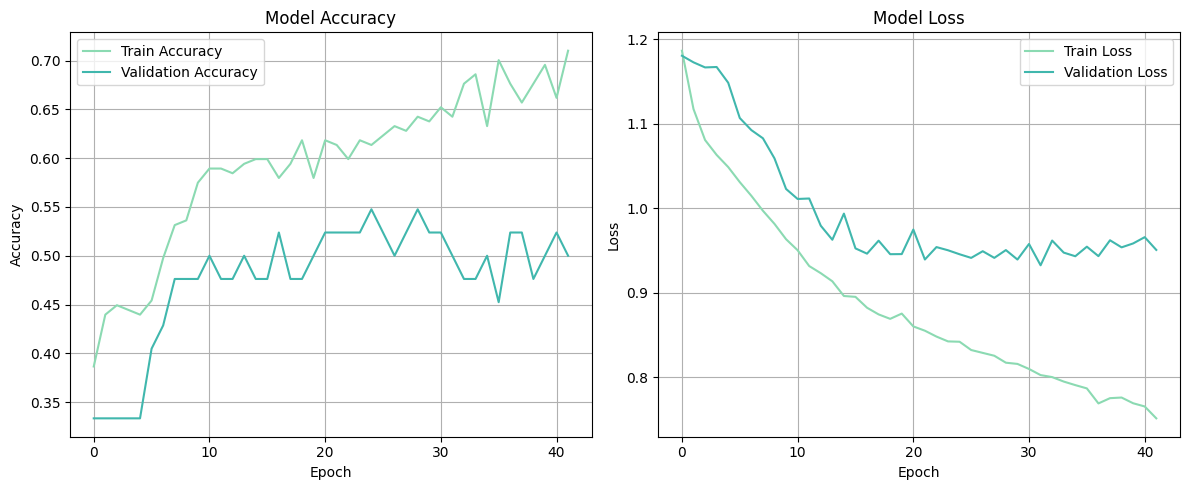

In [106]:
plot_hist(history_model_group_dl)

=== model_group_dl ===
              precision    recall  f1-score   support

           0       0.41      0.39      0.40        18
           1       0.60      0.64      0.62        14
           2       0.50      0.50      0.50        10

    accuracy                           0.50        42
   macro avg       0.50      0.51      0.51        42
weighted avg       0.50      0.50      0.50        42

Accuracy: 0.5000



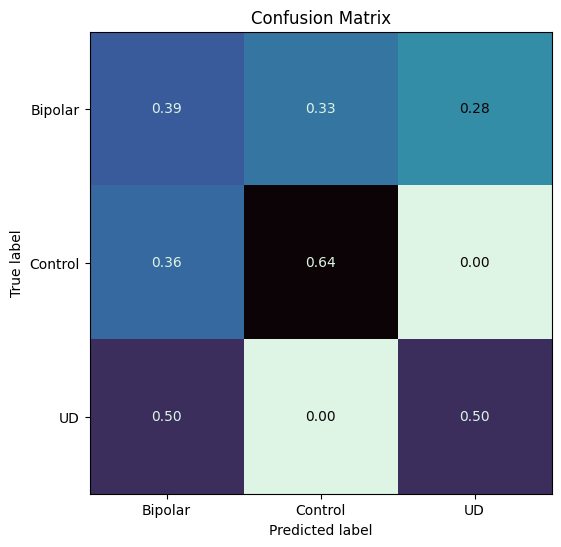

In [107]:
save_nn_history(history_model_group_dl, model_name="model_group_dl", class_names=class_names_group)

# Modeling by `Type`

## Tree-based methods

### Data preparation

In [108]:
X, y = data_prep(df_type, target='type', scale=False)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [109]:
data_splits["dt_type_shallow"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["dt_type_deep"] = data_splits["dt_type_shallow"].copy()
data_splits["rf_type"] = data_splits["dt_type_shallow"].copy()

### Decision Tree

#### Shallow DT

In [110]:
dt_type_shallow = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [111]:
evaluate_and_save(dt_type_shallow, model_name="dt_type_shallow")

=== dt_type_shallow ===
              precision    recall  f1-score   support

        BD I       0.29      0.50      0.37        10
       BD II       0.00      0.00      0.00         8
     Control       0.55      0.79      0.65        14
          UD       1.00      0.50      0.67        10

    accuracy                           0.50        42
   macro avg       0.46      0.45      0.42        42
weighted avg       0.49      0.50      0.46        42

Accuracy: 0.5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Deep DT

In [112]:
dt_type_deep = DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,
    random_state=42
)

In [113]:
evaluate_and_save(dt_type_deep, model_name="dt_type_deep")

=== dt_type_deep ===
              precision    recall  f1-score   support

        BD I       0.33      0.50      0.40        10
       BD II       0.25      0.25      0.25         8
     Control       0.57      0.57      0.57        14
          UD       1.00      0.50      0.67        10

    accuracy                           0.48        42
   macro avg       0.54      0.46      0.47        42
weighted avg       0.56      0.48      0.49        42

Accuracy: 0.4762



### Decision Tree with feature selection

#### ANOVA

##### 5 features

In [114]:
X_selected = select_features(df_type, num_features=5, target='type', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 5 features (anova) for target 'type':
1: Age
2: Right_answers
3: Positive_valence
4: Negative_valence
5: Submissive


In [115]:
data_splits["dt_type_anova_5"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_type_anova_5"] = data_splits["dt_type_anova_5"].copy()

In [116]:
dt_type_anova_5 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [117]:
evaluate_and_save(dt_type_anova_5, model_name="dt_type_anova_5")

=== dt_type_anova_5 ===
              precision    recall  f1-score   support

        BD I       0.29      0.50      0.37        10
       BD II       0.00      0.00      0.00         8
     Control       0.55      0.79      0.65        14
          UD       1.00      0.50      0.67        10

    accuracy                           0.50        42
   macro avg       0.46      0.45      0.42        42
weighted avg       0.49      0.50      0.46        42

Accuracy: 0.5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

##### 7 features

In [118]:
X_selected = select_features(df_type, num_features=7, target='type', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 7 features (anova) for target 'type':
1: Age
2: Right_answers
3: Combined_channel
4: Positive_valence
5: Negative_valence
6: Dominant
7: Submissive


In [119]:
data_splits["dt_type_anova_7"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_type_anova_7"] = data_splits["dt_type_anova_7"].copy()

In [120]:
dt_type_anova_7 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [121]:
evaluate_and_save(dt_type_anova_7, model_name="dt_type_anova_7")

=== dt_type_anova_7 ===
              precision    recall  f1-score   support

        BD I       0.29      0.50      0.37        10
       BD II       0.00      0.00      0.00         8
     Control       0.55      0.79      0.65        14
          UD       1.00      0.50      0.67        10

    accuracy                           0.50        42
   macro avg       0.46      0.45      0.42        42
weighted avg       0.49      0.50      0.46        42

Accuracy: 0.5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Mutual information

In [122]:
X_selected = select_features(df_type, num_features=6, target='type', method='mi')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 6 features (mi) for target 'type':
1: Right_answers
2: Body_video
3: Positive_valence
4: Negative_valence
5: Dominant
6: Submissive


In [123]:
data_splits["dt_type_mi_6"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rf_type_mi_6"] = data_splits["dt_type_mi_6"].copy()

In [124]:
dt_type_mi_6 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

In [125]:
evaluate_and_save(dt_type_mi_6, model_name="dt_type_mi_6")

=== dt_type_mi_6 ===
              precision    recall  f1-score   support

        BD I       0.25      0.50      0.33        10
       BD II       0.40      0.25      0.31         8
     Control       0.62      0.57      0.59        14
          UD       0.75      0.30      0.43        10

    accuracy                           0.43        42
   macro avg       0.50      0.41      0.42        42
weighted avg       0.52      0.43      0.44        42

Accuracy: 0.4286



### Random Forest

In [126]:
rf_type = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [127]:
evaluate_and_save(rf_type, model_name="rf_type")

=== rf_type ===
              precision    recall  f1-score   support

        BD I       0.33      0.40      0.36        10
       BD II       0.40      0.25      0.31         8
     Control       0.61      0.79      0.69        14
          UD       0.57      0.40      0.47        10

    accuracy                           0.50        42
   macro avg       0.48      0.46      0.46        42
weighted avg       0.50      0.50      0.49        42

Accuracy: 0.5000



### Random Forest with feature selection

#### ANOVA

##### 5 features

In [128]:
rf_type_anova_5 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [129]:
evaluate_and_save(rf_type_anova_5, model_name="rf_type_anova_5")

=== rf_type_anova_5 ===
              precision    recall  f1-score   support

        BD I       0.36      0.40      0.38        10
       BD II       0.50      0.38      0.43         8
     Control       0.61      0.79      0.69        14
          UD       0.57      0.40      0.47        10

    accuracy                           0.52        42
   macro avg       0.51      0.49      0.49        42
weighted avg       0.52      0.52      0.51        42

Accuracy: 0.5238



##### 7 features

In [130]:
rf_type_anova_7 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [131]:
evaluate_and_save(rf_type_anova_7, model_name="rf_type_anova_7")

=== rf_type_anova_7 ===
              precision    recall  f1-score   support

        BD I       0.33      0.40      0.36        10
       BD II       0.29      0.25      0.27         8
     Control       0.62      0.71      0.67        14
          UD       0.57      0.40      0.47        10

    accuracy                           0.48        42
   macro avg       0.45      0.44      0.44        42
weighted avg       0.48      0.48      0.47        42

Accuracy: 0.4762



#### Mutual information

In [132]:
rf_type_mi_6 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

In [133]:
evaluate_and_save(rf_type_mi_6, model_name="rf_type_mi_6")

=== rf_type_mi_6 ===
              precision    recall  f1-score   support

        BD I       0.18      0.20      0.19        10
       BD II       0.40      0.25      0.31         8
     Control       0.48      0.79      0.59        14
          UD       0.67      0.20      0.31        10

    accuracy                           0.40        42
   macro avg       0.43      0.36      0.35        42
weighted avg       0.44      0.40      0.38        42

Accuracy: 0.4048



## SVM

### Data preparation

In [134]:
X, y = data_prep(df_type, target='type', scale=True)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [135]:
data_splits["poly_type"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["poly_type_grid"] = data_splits["poly_type"].copy()

data_splits["rbf_type"] = data_splits["poly_type"].copy()
data_splits["rbf_type_grid"] = data_splits["poly_type"].copy()

### Polynomial kernel

In [136]:
poly_type = svm.SVC(kernel='poly', degree=4, C=1, class_weight="balanced").fit(X_train, y_train)

In [137]:
evaluate_and_save(poly_type, model_name="poly_type")

=== poly_type ===
              precision    recall  f1-score   support

        BD I       0.33      0.50      0.40        10
       BD II       0.33      0.38      0.35         8
     Control       0.50      0.50      0.50        14
          UD       0.75      0.30      0.43        10

    accuracy                           0.43        42
   macro avg       0.48      0.42      0.42        42
weighted avg       0.49      0.43      0.43        42

Accuracy: 0.4286



#### Polynomial kernel with GridSearchCV

In [138]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["poly"]
}

grid_poly = GridSearchCV(SVC(class_weight="balanced"), param_grid, cv=5, scoring="f1_macro")
grid_poly.fit(X_train, y_train)

print("Best parameters:", grid_poly.best_params_)

Best parameters: {'C': 1, 'kernel': 'poly'}


In [139]:
poly_type_grid = svm.SVC(kernel='poly', degree=4, C=10, class_weight="balanced").fit(X_train, y_train)

In [140]:
evaluate_and_save(poly_type_grid, model_name="poly_type_grid")

=== poly_type_grid ===
              precision    recall  f1-score   support

        BD I       0.36      0.50      0.42        10
       BD II       0.38      0.38      0.38         8
     Control       0.44      0.50      0.47        14
          UD       0.50      0.20      0.29        10

    accuracy                           0.40        42
   macro avg       0.42      0.39      0.39        42
weighted avg       0.42      0.40      0.39        42

Accuracy: 0.4048



### RBF kernel

In [141]:
rbf_type = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [142]:
evaluate_and_save(rbf_type, model_name="rbf_type")

=== rbf_type ===
              precision    recall  f1-score   support

        BD I       0.50      0.20      0.29        10
       BD II       0.14      0.12      0.13         8
     Control       0.62      0.57      0.59        14
          UD       0.56      1.00      0.71        10

    accuracy                           0.50        42
   macro avg       0.45      0.47      0.43        42
weighted avg       0.48      0.50      0.46        42

Accuracy: 0.5000



#### RBF kernel with GridSearchCV

In [143]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
    "kernel": ["rbf"]
}

grid_rbf = GridSearchCV(SVC(class_weight="balanced"), param_grid, cv=5, scoring="f1_macro")
grid_rbf.fit(X_train, y_train)

print("Best parameters:", grid_rbf.best_params_)

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [144]:
rbf_type_grid = svm.SVC(kernel='rbf', gamma=10, C=1, class_weight="balanced").fit(X_train, y_train)

In [145]:
evaluate_and_save(rbf_type_grid, model_name="rbf_type_grid")

=== rbf_type_grid ===
              precision    recall  f1-score   support

        BD I       0.42      0.50      0.45        10
       BD II       0.17      0.12      0.14         8
     Control       0.53      0.71      0.61        14
          UD       0.60      0.30      0.40        10

    accuracy                           0.45        42
   macro avg       0.43      0.41      0.40        42
weighted avg       0.45      0.45      0.43        42

Accuracy: 0.4524



## SVM with feature selection

### ANOVA

#### 5 features

In [146]:
X_selected = select_features(df_type, num_features=5, target='type', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 5 features (anova) for target 'type':
1: Age
2: Right_answers
3: Positive_valence
4: Negative_valence
5: Submissive


In [147]:
data_splits["poly_type_anova_5"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_type_anova_5"] = data_splits["poly_type_anova_5"].copy()

##### Polynomial kernel

In [148]:
poly_type_anova_5 = svm.SVC(kernel='poly', degree=4, C=1, class_weight="balanced").fit(X_train, y_train)

In [149]:
evaluate_and_save(poly_type_anova_5, model_name="poly_type_anova_5")

=== poly_type_anova_5 ===
              precision    recall  f1-score   support

        BD I       0.25      0.40      0.31        10
       BD II       0.40      0.50      0.44         8
     Control       0.36      0.29      0.32        14
          UD       0.60      0.30      0.40        10

    accuracy                           0.36        42
   macro avg       0.40      0.37      0.37        42
weighted avg       0.40      0.36      0.36        42

Accuracy: 0.3571



##### RBF kernel

In [150]:
rbf_type_anova_5 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [151]:
evaluate_and_save(rbf_type_anova_5, model_name="rbf_type_anova_5")

=== rbf_type_anova_5 ===
              precision    recall  f1-score   support

        BD I       0.50      0.20      0.29        10
       BD II       0.14      0.38      0.21         8
     Control       1.00      0.14      0.25        14
          UD       0.60      0.90      0.72        10

    accuracy                           0.38        42
   macro avg       0.56      0.40      0.37        42
weighted avg       0.62      0.38      0.36        42

Accuracy: 0.3810



#### 7 features

In [152]:
X_selected = select_features(df_type, num_features=7, target='type', method='anova')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 7 features (anova) for target 'type':
1: Age
2: Right_answers
3: Combined_channel
4: Positive_valence
5: Negative_valence
6: Dominant
7: Submissive


In [153]:
data_splits["poly_type_anova_7"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_type_anova_7"] = data_splits["poly_type_anova_7"].copy()

##### Polynomial kernel

In [154]:
poly_type_anova_7 = svm.SVC(kernel='poly', degree=4, C=1, class_weight="balanced").fit(X_train, y_train)

In [155]:
evaluate_and_save(poly_type_anova_7, model_name="poly_type_anova_7")

=== poly_type_anova_7 ===
              precision    recall  f1-score   support

        BD I       0.42      0.50      0.45        10
       BD II       0.40      0.75      0.52         8
     Control       0.58      0.50      0.54        14
          UD       0.33      0.10      0.15        10

    accuracy                           0.45        42
   macro avg       0.43      0.46      0.42        42
weighted avg       0.45      0.45      0.42        42

Accuracy: 0.4524



##### RBF kernel

In [156]:
rbf_type_anova_7 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [157]:
evaluate_and_save(rbf_type_anova_7, model_name="rbf_type_anova_7")

=== rbf_type_anova_7 ===
              precision    recall  f1-score   support

        BD I       0.67      0.20      0.31        10
       BD II       0.17      0.25      0.20         8
     Control       0.60      0.43      0.50        14
          UD       0.53      0.90      0.67        10

    accuracy                           0.45        42
   macro avg       0.49      0.44      0.42        42
weighted avg       0.52      0.45      0.44        42

Accuracy: 0.4524



### Mutual information

In [158]:
X_selected = select_features(df_type, num_features=6, target='type', method='mi')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X_selected, y)

Top 6 features (mi) for target 'type':
1: Right_answers
2: Audio_prosody
3: Combined_channel
4: Positive_valence
5: Dominant
6: Submissive


In [159]:
data_splits["poly_type_mi_6"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["rbf_type_mi_6"] = data_splits["poly_type_mi_6"].copy()

#### Polynomial kernel

In [160]:
poly_type_mi_6 = svm.SVC(kernel='poly', degree=4, C=1, class_weight="balanced").fit(X_train, y_train)

In [161]:
evaluate_and_save(poly_type_mi_6, model_name="poly_type_mi_6")

=== poly_type_mi_6 ===
              precision    recall  f1-score   support

        BD I       0.36      0.40      0.38        10
       BD II       0.15      0.25      0.19         8
     Control       0.56      0.36      0.43        14
          UD       0.44      0.40      0.42        10

    accuracy                           0.36        42
   macro avg       0.38      0.35      0.36        42
weighted avg       0.41      0.36      0.37        42

Accuracy: 0.3571



#### RBF kernel

In [162]:
rbf_type_mi_6 = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)

In [163]:
evaluate_and_save(rbf_type_mi_6, model_name="rbf_type_mi_6")

=== rbf_type_mi_6 ===
              precision    recall  f1-score   support

        BD I       0.00      0.00      0.00        10
       BD II       0.07      0.12      0.09         8
     Control       0.57      0.29      0.38        14
          UD       0.43      0.90      0.58        10

    accuracy                           0.33        42
   macro avg       0.27      0.33      0.26        42
weighted avg       0.31      0.33      0.28        42

Accuracy: 0.3333



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## Neural Networks

### Data preparation

In [164]:
X, y_raw = data_prep(df_type, target='type', scale=True)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names_type = label_encoder.classes_

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [165]:
data_splits["model_type"] = {
    "X_train": X_train, "X_val": X_val, "X_test": X_test,
    "y_train": y_train, "y_val": y_val, "y_test": y_test
}

data_splits["model_type_reg"] = data_splits["model_type"].copy()
data_splits["model_type_dl"] = data_splits["model_type"].copy()

### Basic neural network

In [166]:
model_type = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(set(y)), activation='softmax')
])

model_type.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [167]:
history_model_type = model_type.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=50,
                                batch_size=32,
                                verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.1383 - loss: 1.4210 - val_accuracy: 0.3333 - val_loss: 1.3680
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4348 - loss: 1.3353 - val_accuracy: 0.3333 - val_loss: 1.3482
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4178 - loss: 1.3162 - val_accuracy: 0.3333 - val_loss: 1.3370
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4250 - loss: 1.2857 - val_accuracy: 0.3333 - val_loss: 1.3329
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3904 - loss: 1.2913 - val_accuracy: 0.3333 - val_loss: 1.3305
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4562 - loss: 1.2245 - val_accuracy: 0.3333 - val_loss: 1.3312
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4416 - loss: 1.2287 - val_accuracy: 0.3333 - val_loss: 1.3284
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3891 - loss: 1.2756 - val_accuracy: 0.3333 - val_loss: 1.3212

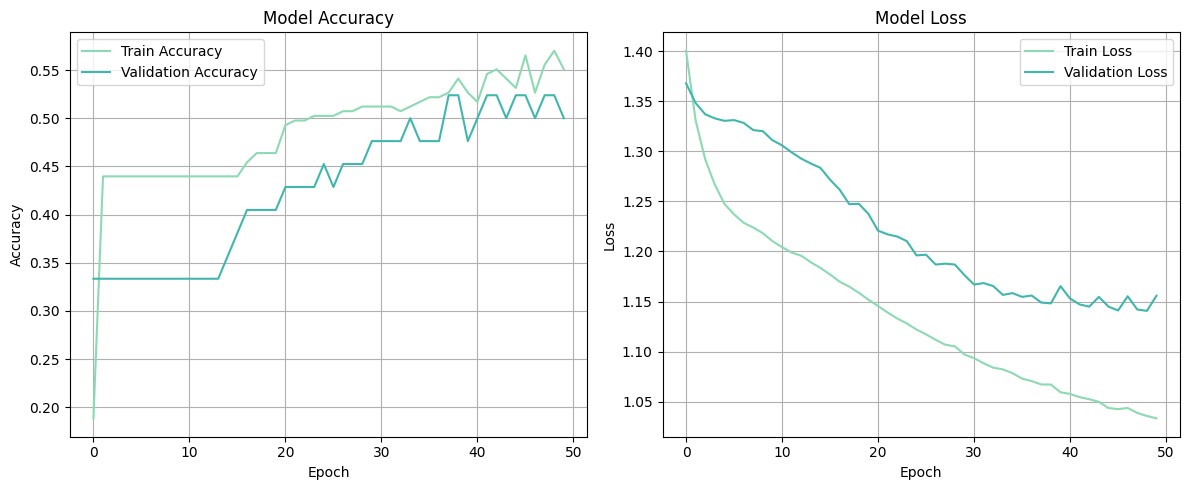

In [168]:
plot_hist(history_model_type)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

=== model_type ===
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.00      0.00      0.00         8
           2       0.48      1.00      0.65        14
           3       0.55      0.60      0.57        10

    accuracy                           0.50        42
   macro avg       0.38      0.43      0.35        42
weighted avg       0.41      0.50      0.39        42

Accuracy: 0.5000



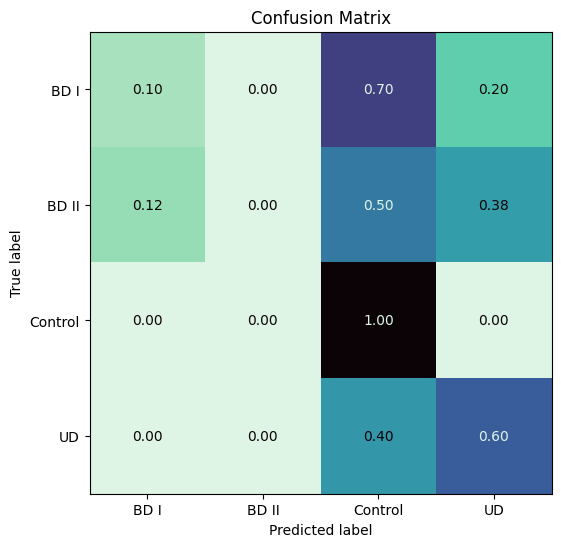

In [169]:
save_nn_history(history_model_type, "model_type", class_names=class_names_type)

### Neural network with regularization and early stopping

In [170]:
model_type_reg = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(len(set(y)), activation='softmax')
])

model_type_reg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [171]:
history_model_type_reg = model_type_reg.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.4465 - loss: 1.3294 - val_accuracy: 0.3333 - val_loss: 1.3913
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4533 - loss: 1.2803 - val_accuracy: 0.3333 - val_loss: 1.4022
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4223 - loss: 1.2836 - val_accuracy: 0.3333 - val_loss: 1.3959
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4472 - loss: 1.2605 - val_accuracy: 0.3333 - val_loss: 1.3780
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4323 - loss: 1.2537 - val_accuracy: 0.3333 - val_loss: 1.3708
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4526 - loss: 1.2394 - val_accuracy: 0.3333 - val_loss: 1.3721
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4440 - loss: 1.2308 - val_accuracy: 0.3333 - val_loss: 1.3667
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4532 - loss: 1.2215 - val_accuracy: 0.3571 - val_loss

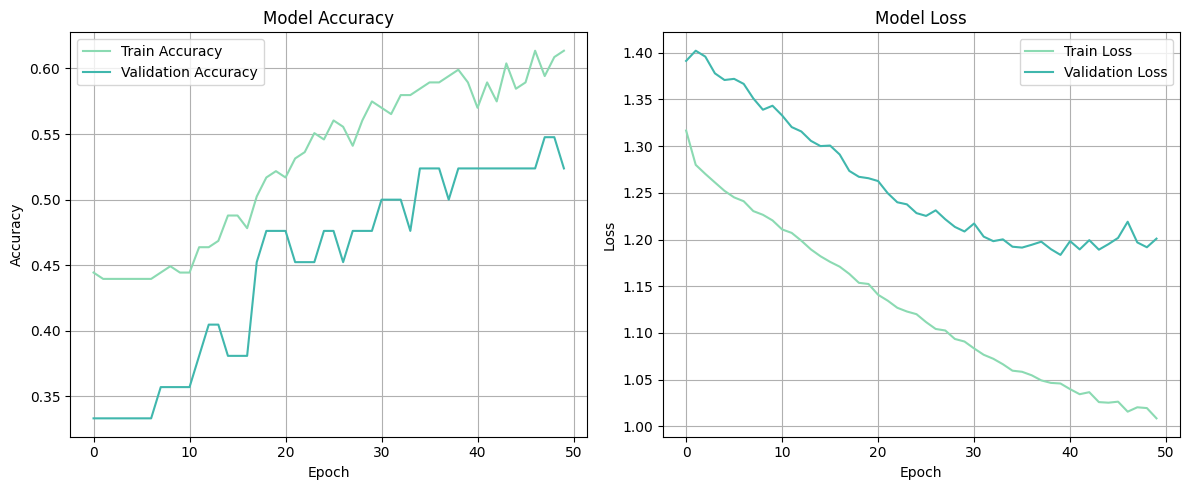

In [172]:
plot_hist(history_model_type_reg)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

=== model_type_reg ===
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.00      0.00      0.00         8
           2       0.52      1.00      0.68        14
           3       0.58      0.70      0.64        10

    accuracy                           0.52        42
   macro avg       0.36      0.45      0.37        42
weighted avg       0.39      0.52      0.42        42

Accuracy: 0.5238



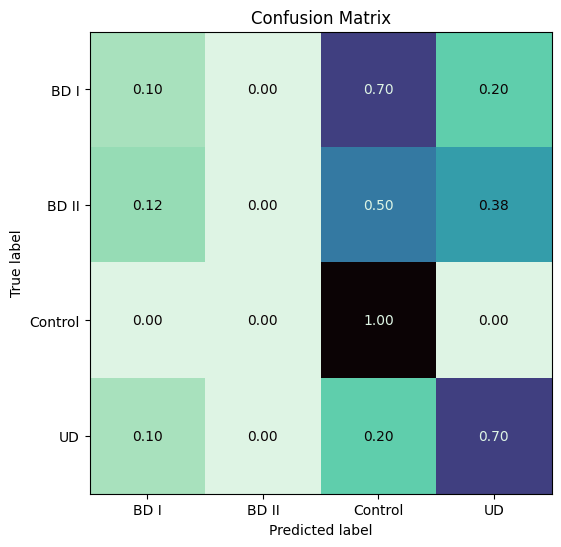

In [173]:
save_nn_history(history_model_type_reg, "model_type_reg", class_names=class_names_type)

### Deep learning model

In [174]:
model_type_dl = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)),
    layers.Dense(len(set(y)), activation='softmax')
])

model_type_dl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [175]:
history_model_type_dl = model_type_dl.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.3634 - loss: 1.4879 - val_accuracy: 0.3333 - val_loss: 1.4707
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4276 - loss: 1.4238 - val_accuracy: 0.3333 - val_loss: 1.4507
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4742 - loss: 1.3397 - val_accuracy: 0.3333 - val_loss: 1.4629
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4260 - loss: 1.3466 - val_accuracy: 0.3333 - val_loss: 1.4571
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4258 - loss: 1.3413 - val_accuracy: 0.3333 - val_loss: 1.4267
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4374 - loss: 1.3018 - val_accuracy: 0.3333 - val_loss: 1.4032
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4182 - loss: 1.3153 - val_accuracy: 0.3333 - val_loss: 1.3750
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4340 - loss: 1.2825 - val_accuracy: 0.4048 - val_loss

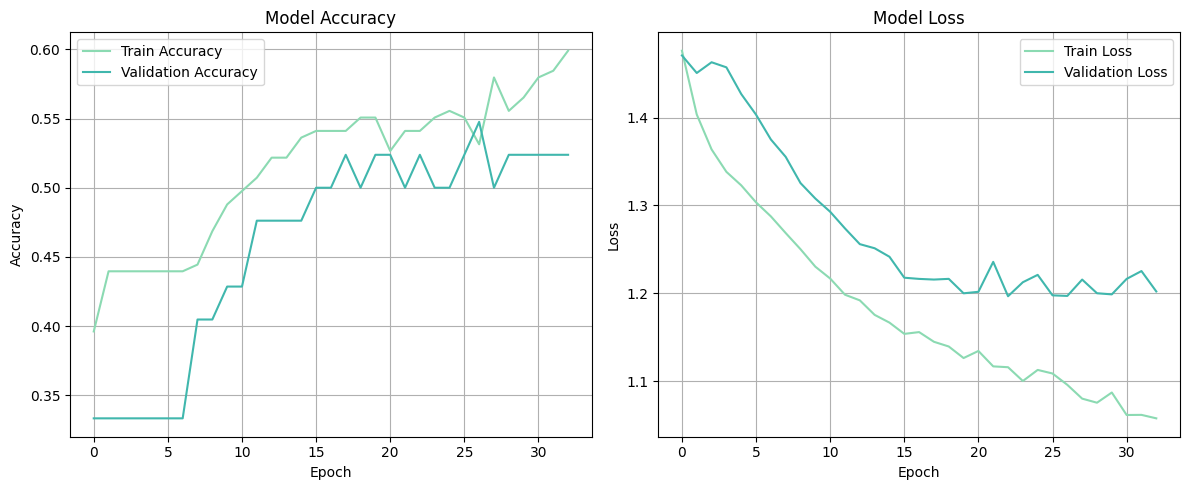

In [176]:
plot_hist(history_model_type_dl)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

=== model_type_dl ===
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.00      0.00      0.00         8
           2       0.52      1.00      0.68        14
           3       0.58      0.70      0.64        10

    accuracy                           0.52        42
   macro avg       0.36      0.45      0.37        42
weighted avg       0.39      0.52      0.42        42

Accuracy: 0.5238



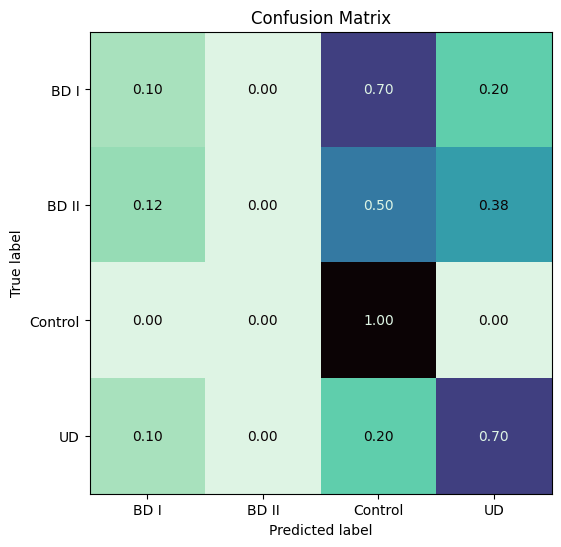

In [177]:
save_nn_history(history_model_type_dl, "model_type_dl", class_names=class_names_type)

# Final evaluation

In [178]:
best_group, best_type = get_top_models(save_path, top_n=5)

## Modeling by `Group`

In [179]:
print(best_group)

                model  accuracy  f1_weighted
6    rf_group_anova_5  0.666667     0.656776
2    dt_group_anova_5  0.619048     0.622741
7    rf_group_anova_7  0.619048     0.602834
16  rbf_group_anova_7  0.595238     0.587709
1       dt_group_deep  0.571429     0.572728


### \#1

In [180]:
evaluate_and_save(rf_group_anova_5, "rf_group_anova_5", test=True)

=== rf_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.62      0.67      0.64        12
     Control       0.71      0.71      0.71        14
          UD       1.00      0.50      0.67         2

    accuracy                           0.68        28
   macro avg       0.78      0.63      0.67        28
weighted avg       0.69      0.68      0.68        28

Accuracy: 0.6786



### \#2

In [181]:
evaluate_and_save(dt_group_anova_5, "dt_group_anova_5", test=True)

=== dt_group_anova_5 ===
              precision    recall  f1-score   support

     Bipolar       0.46      0.50      0.48        12
     Control       0.62      0.57      0.59        14
          UD       0.50      0.50      0.50         2

    accuracy                           0.54        28
   macro avg       0.53      0.52      0.52        28
weighted avg       0.54      0.54      0.54        28

Accuracy: 0.5357



### \#3

In [182]:
evaluate_and_save(rf_group_anova_7, "rf_group_anova_7", test=True)

=== rf_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.55      0.50      0.52        12
     Control       0.67      0.71      0.69        14
          UD       0.50      0.50      0.50         2

    accuracy                           0.61        28
   macro avg       0.57      0.57      0.57        28
weighted avg       0.60      0.61      0.60        28

Accuracy: 0.6071



### \#4

In [183]:
evaluate_and_save(rbf_group_anova_7, "rbf_group_anova_7", test=True)

=== rbf_group_anova_7 ===
              precision    recall  f1-score   support

     Bipolar       0.40      0.17      0.24        12
     Control       0.64      0.64      0.64        14
          UD       0.22      1.00      0.36         2

    accuracy                           0.46        28
   macro avg       0.42      0.60      0.41        28
weighted avg       0.51      0.46      0.45        28

Accuracy: 0.4643



### \#5

In [184]:
evaluate_and_save(dt_group_deep, "dt_group_deep", test=True)

=== dt_group_deep ===
              precision    recall  f1-score   support

     Bipolar       0.60      0.50      0.55        12
     Control       0.73      0.79      0.76        14
          UD       0.33      0.50      0.40         2

    accuracy                           0.64        28
   macro avg       0.56      0.60      0.57        28
weighted avg       0.65      0.64      0.64        28

Accuracy: 0.6429



## Modeling by `Type`

In [185]:
print(best_type)

              model  accuracy  f1_weighted
28  rf_type_anova_5   0.52381     0.513547
42   model_type_reg   0.52381     0.415787
43    model_type_dl   0.52381     0.415787
27          rf_type   0.50000     0.486400
22  dt_type_shallow   0.50000     0.462600


### \#1

In [186]:
evaluate_and_save(rf_type_anova_5, "rf_type_anova_5", test=True)

=== rf_type_anova_5 ===
              precision    recall  f1-score   support

        BD I       0.25      0.22      0.24         9
       BD II       0.00      0.00      0.00         3
     Control       0.67      0.71      0.69        14
          UD       0.33      0.50      0.40         2

    accuracy                           0.46        28
   macro avg       0.31      0.36      0.33        28
weighted avg       0.44      0.46      0.45        28

Accuracy: 0.4643



### \#2

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

=== model_type_reg ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         3
           2       0.60      0.86      0.71        14
           3       0.29      1.00      0.44         2

    accuracy                           0.50        28
   macro avg       0.22      0.46      0.29        28
weighted avg       0.32      0.50      0.38        28

Accuracy: 0.5000



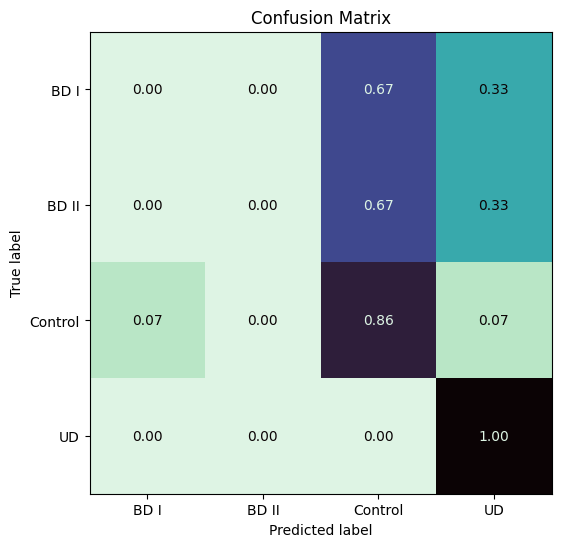

In [187]:
save_nn_history(history_model_type_reg, "model_type_reg", class_names=class_names_type, test=True)

### \#3

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

=== model_type_dl ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         3
           2       0.62      0.93      0.74        14
           3       0.29      1.00      0.44         2

    accuracy                           0.54        28
   macro avg       0.23      0.48      0.30        28
weighted avg       0.33      0.54      0.40        28

Accuracy: 0.5357



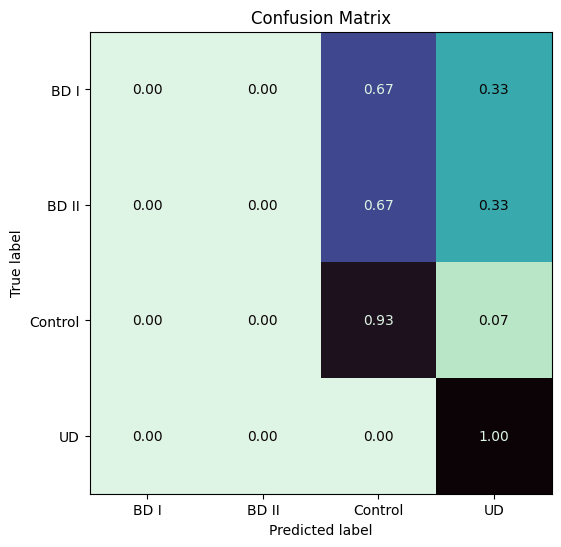

In [188]:
save_nn_history(history_model_type_dl, "model_type_dl", class_names=class_names_type, test=True)

### \#4

In [189]:
evaluate_and_save(rf_type, "rf_type", test=True)

=== rf_type ===
              precision    recall  f1-score   support

        BD I       0.20      0.11      0.14         9
       BD II       0.00      0.00      0.00         3
     Control       0.65      0.79      0.71        14
          UD       0.25      0.50      0.33         2

    accuracy                           0.46        28
   macro avg       0.27      0.35      0.30        28
weighted avg       0.41      0.46      0.42        28

Accuracy: 0.4643



### \#5

In [190]:
evaluate_and_save(dt_type_shallow, "dt_type_shallow", test=True)

=== dt_type_shallow ===
              precision    recall  f1-score   support

        BD I       0.45      0.56      0.50         9
       BD II       0.00      0.00      0.00         3
     Control       0.56      0.64      0.60        14
          UD       1.00      0.50      0.67         2

    accuracy                           0.54        28
   macro avg       0.50      0.42      0.44        28
weighted avg       0.50      0.54      0.51        28

Accuracy: 0.5357



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m